#Implementing ATARI-game "Breakout" as a Deep Q-Network

#General GYM commands

###Create (vector) environment
`env = gym.make("ENVIRONMENT_NAME")` <br>
`envs = gym.vector.make("ENVIRONMENT_NAME", N_ENVIRONMENTS)`

###Reset environment to initial state
`observation, info = env.reset()` <br>
***NOTE: In vectorized environment, we do not have to reset the environment when it is terminated/truncated, because whenever a sub-environment finishes, it starts again automatically. This is for efficiency, because we will end at different time points for the sub-environments, and can't afford to wait until all are terminated.

###Sample a random action in environment
`action = env.action_space.sample()`

###Take an action in environment
`observation, reward, terminated, truncated, info = env.step(action)`
- observation = new state (image)
- reward = reward (int)
- terminated = terminal state reached? (bool)
- truncated = max sequence length reached? (bool)
- info = human-readable information

#Breakout (ALE/Breakout-v5)

###Action Space (`env.action_space`)
***There are 4 different actions conducted by pressing 4 different buttoms.
- action 0 (NOOP): perform no action
- action 1 (FIRE): restart after losing a life
- action 2 (RIGHT): move platform to the right
- action 3 (LEFT): move platform to the left

###Observation Space (`env.observation_space`)
The output state / observation is an image with 210x160 pixels + 3 color channels (rgb), i.e. a vector of size **(210,160,3)**. <br>
The observation space is a vector of size **(0,255,(210,160,3),uint8)**, i.e. each data point in this space is an image of size (210,160,3), where each pixel can take an unsigned integer (with 8 Bits) - value between [0,255].

###Frameskip
Uses a frameskip of **4**: Instead of playing each frame of the game independently, we play 4 frames at once, i.e. we do the same action for all 4 frames with a probability of 0.25.

# Tool Setup

Gym environment (Atari Games): https://gymnasium.farama.org/#

In [1]:
pip install "gymnasium[atari, accept-rom-license]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gymnasium-0.28.1-py3-none-any.whl (925 kB)
  Using cached jax_jumpy-1.0.0-py3-none-any.whl (20 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Using cached AutoROM-0.4.2-py3-none-any.whl (16 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=c54207e7d1486342c41afb84a493643368a357dc872aec9447a395c590d1fc41
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-ro

In [2]:
import gymnasium as gym    #for atari games environment
import tensorflow as tf    #for deep ANN
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import gc

#Experience Replay Buffer
= stores all collected samples, i.e. works as a dataset that is used for training our Q-Network


In [3]:
class ExperienceReplayBuffer:

  def __init__(self, max_size: int, environment_name: str, parallel_game_unrolls: int, observation_preprocessing_function: callable, unroll_steps: int):
    self.max_size = max_size                                                      #amount of max samples that can be stored
    self.environment_name = environment_name                                      #the environment we use
    self.parallel_game_unrolls = parallel_game_unrolls                            #amount of environments, in which we play in parallel
    self.observation_preprocessing_function = observation_preprocessing_function  #preprocessing function used to [...] the observations
    self.unroll_steps = unroll_steps                                              #amount of steps that we take in each sub-environment to generate data sample
    self.envs = gym.vector.make(environment_name, self.parallel_game_unrolls)     #create vectorized environment to allow sampling from multiple envs in parallel
    self.num_possible_actions = self.envs.single_action_space.n                   #amount of possible actions that can be taken in a sub-environment
    self.current_states, _ = self.envs.reset()                                    #stores the current state of each sub-env
    self.data = []                                                                #stores all tf.datasets that each represent the information of a single step at time step t in all sub-environments

  def sample_epsilon_greedy(self, dqn_network, epsilon: float):
    """ sample an action from DQN given the observation by using  epsilon greedy approach """
    #get observation / current state
    observations = self.observation_preprocessing_function(self.current_states)
    #run q-network on observation to estimate q-values
    q_values = dqn_network(observations)                                                                                                           #tensor of type tf.float32 + shape (parallel_game_unrolls, num_actions)
    #find best action [0 or 1 or 2 or 3] for each sub-environment
    greedy_actions = tf.argmax(q_values, axis=1)                                                                                                   #tensor of type tf.int64 + shape(parallel_game_unrolls,1)
    #select random action [0 or 1 or 2 or 3] for each sub-environment
    random_actions = tf.random.uniform(shape=(self.parallel_game_unrolls,1), minval=0, maxval=self.num_possible_actions, dtype=tf.int64)           #tensor of type tf.int64 + shape(parallel_game_unrolls,1)
    #create a boolean vector using epsilon [True (with prob = 1-epsilon), False (with prob = epsilon)]
    epsilon_sampling = tf.random.uniform(shape=(self.parallel_game_unrolls,1), minval=0, maxval=1, dtype=tf.float32) > epsilon                     #tensor of type tf.bool + shape(parallel_game_unrolls,1)
    #get action by applying boolean vector onto the 2 choice vectors greedy and random actions [True = greedy/vector1, False = random/vector2]
    actions = tf.where(epsilon_sampling,greedy_actions,random_actions).numpy()                                                                     #tensor of type tf.int64 + shape(parallel_game_unrolls,1)
    return actions

  def fill_with_samples(self, dqn_network, epsilon: float):
    """ add new samples into the ERB """
    states_list = []
    actions_list = []
    rewards_list = []
    subsequent_states_list = []
    terminateds_list = []

    #GENERATE DATA: conduct 'unroll_steps' steps in each sub-environment
    for i in range(self.unroll_steps):
      #choose next action using epsilon greedy
      actions = self.sample_epsilon_greedy(dqn_network, epsilon)
      #actions is a 2d array (for some reason) so flatten it to 1d array
      actions = np.array(actions).flatten()
      #conduct action
      next_states, rewards, terminateds, _, _ = self.envs.step(actions)
      #save observation, action, reward, next observation
      states_list.append(self.current_states)
      actions_list.append(actions)
      rewards_list.append(rewards)
      subsequent_states_list.append(next_states)
      terminateds_list.append(terminateds)
      #update states
      self.current_states = next_states

    #EXTRACT INFORMATION TUPLES OF EACH SUB-ENVIRONMENT
    def data_generator():
      for states_batch, actions_batch, rewards_batch, subsequent_states_batch, terminateds_batch in zip(states_list, actions_list, rewards_list, subsequent_states_list, terminateds_list):
        #for each sub-environment
        for game_idx in range(self.parallel_game_unrolls):
          #get state, action, reward, next state, terminated
          state = states_batch[game_idx,:,:,:] #state is given in high, width, color channels
          action = actions_batch[game_idx]
          reward = rewards_batch[game_idx]
          subsequent_state = subsequent_states_batch[game_idx]
          terminated = terminateds_batch[game_idx]
          yield(state,action,reward,subsequent_state,terminated)

    #FEED INFORMATION TUPLES INTO A tf.DATASET
    #give shape + data type for state,                                   action,                                  reward,                                  subsequent_state,                                 terminated
    ds_tensor_specs = (tf.TensorSpec(shape=(210,160,3), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(210,160,3), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.bool))
    #create tf.dataset that store all information of this step taken in all sub-environments
    new_samples_ds = tf.data.Dataset.from_generator(data_generator, output_signature=ds_tensor_specs)

    #ADD NEW DATAPOINT/SUB-DATASET TO OUR DATASET/ERB
    #preprocess dataset
    new_samples_ds = new_samples_ds.map(lambda state, action, reward, subsequent_state, terminated: (self.observation_preprocessing_function(state), action, reward,  self.observation_preprocessing_function(subsequent_state), terminated))
    new_samples_ds = new_samples_ds.cache().shuffle(buffer_size=self.unroll_steps * self.parallel_game_unrolls, reshuffle_each_iteration=True)
    #run through dataset once (without doing sth) to apply preprocessing steps and to make sure that cache is applied
    for elem in new_samples_ds:
      continue
    #save dataset
    self.data.append(new_samples_ds)
    #get total amount of data samples (# of datasets * # of steps considered per sample * # of sub-environments)
    datapoints_in_data = len(self.data) * self.unroll_steps * self.parallel_game_unrolls
    #check if maximum amount of data samples is exceeded
    if datapoints_in_data > self.max_size:
      #delete oldest data sample to stay below max size
      self.data.pop(0)

  def create_dataset(self):
    """ create td.data.Dataset object from the ERB """
    erb_dataset = tf.data.Dataset.sample_from_datasets(datasets=self.data, weights=[1/float(len(self.data)) for _ in self.data], stop_on_empty_dataset=False)
    return erb_dataset


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def observation_preprocessing_function(observation):
  """ convert an obsevation (state) to a tensor of type tf.float32, shape (84,84,3) """

  #reduce image size from (210,160,3) to (84,84,3) for efficiency
  observation = tf.image.resize(observation, size=(84,84), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) #ATARI has low-resolution graphics and sharp pixelated edges, so we use Nearest Neighbor (instead of Linear Interpolation) as method to preserve those characteristics and avoid smoothing/blurring artifacts
  #change data type from  tf.uint8 to tf.float32
  observation = tf.cast(observation, dtype=tf.float32)
  #zero-center, i.e. put data in the range [-1.0, 1.0]
  observation = observation / 128.0 - 1.0

  return observation


#Deep Q-Network
= a neural network that gets an image of Atari game state as input and returns the choosen action (the picked buttoms) as output

In [5]:
def create_dqn_network(num_actions: int):
  """ create deep Q-network agent using functional API """

  #create input for functional tf.model api (we reduce the image size for efficiency)
  input_layer = tf.keras.Input(shape=(84,84,3), dtype=tf.float32)
  #convolutional layers using residual/skip connections
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(input_layer)
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
  #use global average pooling
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  #apply densely connected layer
  x = tf.keras.layers.Dense(units=64, activation='relu')(x)
  #output layer (NO residual connection!) using no activation; creates q-values for all actions
  y = tf.keras.layers.Dense(units=num_actions, activation='linear')(x)

  model = tf.keras.Model(inputs=input_layer, outputs=y)
  return model

In [6]:
def train_dqn(train_dqn_network, target_network, dataset, optimizer, discount_factor: float, num_training_steps: int, batch_size: int=256):
  """ Train Deep Q-Network in 'num_training_steps' steps using 'optimizer' """

  # use minibatches
  dataset = dataset.batch(batch_size).prefetch(4)

  @tf.function
  def training_step(q_targets, observations, actions):
    """ A sub-function for a single training step"""
    with tf.GradientTape() as tape:
      # estimate q-values for the actions that we actually took in the sample
      q_predictions_all_actions = train_dqn_network(observations)  # shape of (batch_size, num_actions)
      q_predictions = tf.gather(q_predictions_all_actions, actions, batch_dims=1)
      # compute MSE loss
      loss = tf.reduce_mean(tf.square(q_predictions - q_targets))
    # calculate the gradients
    gradients = tape.gradient(loss, train_dqn_network.trainable_variables)
    # apply gradients on network
    optimizer.apply_gradients(zip(gradients, train_dqn_network.trainable_variables))
    # return loss for prediction error tracker
    return loss

  losses = []
  q_values = []
  for i, state_transition in enumerate(dataset):
    state, action, reward, subsequent_state, terminated = state_transition
    # cast reward to float32
    reward = tf.cast(reward, tf.float32)
    # get q-values from target network
    all_q_values = target_network(subsequent_state)
    # select max q-value of each sub-environment step
    max_q_values = tf.math.reduce_max(all_q_values, axis=1)
    # save mean of all q-values for q-value tracker
    q_values.append(np.mean(all_q_values.numpy()))
    # compute q-targets
    q_targets = reward + (discount_factor * max_q_values * (1 - tf.cast(terminated, tf.float32)))
    # conduct a training step: update network parameters by gradient descent
    loss = training_step(q_targets, state, action)
    loss = loss.numpy()
    # save loss for prediction error tracker
    losses.append(loss)
    # check if training done
    if i >= num_training_steps:
      break

  # return the average over the losses for prediction error tracker + the q-values for the q-value tracker
  return np.mean(losses), np.mean(q_values)


#RL application

In [7]:
def test_q_network(test_dqn_network, environment_name: str, num_parallel_tests: int, discount_factor: float, preprocessing_function: callable, test_epsilon: float = 0.05):
    envs = gym.vector.make(environment_name, num_parallel_tests)
    states, _ = envs.reset()

    done = False
    timestep = 0
    returns = np.zeros(num_parallel_tests)
    episodes_finished = np.zeros(num_parallel_tests, dtype=bool)
    num_possible_actions = envs.single_action_space.n

    while not done:
        states = preprocessing_function(states)
        q_values = test_dqn_network(states)
        greedy_actions = tf.argmax(q_values, axis=1)
        random_actions = tf.random.uniform(shape=(num_parallel_tests, 1), minval=0, maxval=num_possible_actions, dtype=tf.int64)
        epsilon_sampling = tf.random.uniform(shape=(num_parallel_tests, 1), minval=0, maxval=1, dtype=tf.float32) > test_epsilon
        actions = tf.where(epsilon_sampling, greedy_actions, random_actions).numpy().flatten().astype(int)
        next_states, rewards, terminateds, _, _ = envs.step(actions)

        episodes_finished = np.logical_or(episodes_finished, terminateds)
        returns += ((discount_factor ** timestep) * rewards) * (np.logical_not(episodes_finished).astype(np.float32))
        timestep += 1
        done = np.all(episodes_finished)

    return np.mean(returns)


In [8]:
def polyak_averaging_weights(source_network, target_network, polyak_averaging_factor: float):
  """
    copy the weights of a source network to the a target network in a Polyak averaging way,
    i.e. average Source and Target network's weights in a weighted manner
    --> If 'polyak_averaging_factor' = 0, then we copy WHOLE source network's weights.
  """

  for target_weights, source_weights in zip(target_network.weights, source_network.weights):
        target_weights.assign(polyak_averaging_factor * source_weights + (1 - polyak_averaging_factor) * target_weights)


In [9]:
def visualize_results(results_df, step):
    # Create a figure with subplots
    fig, axis = plt.subplots(3, 1, figsize=(12, 12))
    # Plot the average return
    sns.lineplot(x=results_df.index, y='average_return', data=results_df, ax=axis[0])
    # Plot the average loss
    sns.lineplot(x=results_df.index, y='average_loss', data=results_df, ax=axis[1])
    # Plot the average q-values
    sns.lineplot(x=results_df.index, y='average q-values', data=results_df, ax=axis[2])
    # Create a timestring from the timestamp
    timestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # Save the figure with a unique filename
    filename = f"results_{step}_{timestring}.png"
    plt.savefig(filename)
    plt.show()

In [10]:
def dqn():

  ENVIRONMENT_NAME = "ALE/Breakout-v5"
  NUMBER_ACTIONS = gym.make(ENVIRONMENT_NAME).action_space.n
  MAX_SIZE = 1000 #100000
  PARALLEL_GAME_UNROLLS = 10 #128
  UNROLL_STEPS = 4
  PREFILL_STEPS = 100
  EPSILON = 0.2
  DISCOUNT_FACTOR = 0.095
  POLYAK_AVERAGING_FACTOR = 0.99           #the more training we do in-between updating steps, the smaller can this factor be
  OPTIMIZER = tf.keras.optimizers.Adam()
  NUM_TRAINING_STEPS_PER_ITERATION = 16
  TRAIN_BATCH_SIZE = 350 #512
  NUM_TRAINING_ITERATIONS = 50001 #50000
  TEST_EVERY_N_STEPS = 50
  TEST_NUM_PARALLEL_ENVIRONMENTS = 10 #128

  #create experience replay buffer, DQN agent/network (= the network we train), Target network (= the network we use to calculate the Q-estimation targets)
  erb = ExperienceReplayBuffer(MAX_SIZE, ENVIRONMENT_NAME, PARALLEL_GAME_UNROLLS, observation_preprocessing_function, UNROLL_STEPS)
  dqn_agent = create_dqn_network(NUMBER_ACTIONS)
  target_network = create_dqn_network(NUMBER_ACTIONS)

  #initialize target network with identical weights as the DQN network
  polyak_averaging_weights(dqn_agent, target_network, polyak_averaging_factor = 0.0)

  #initialize trackers for return, prediction error, average q-values
  return_tracker = []
  dqn_prediction_error_tracker = []
  avg_q_values_tracker = []

  #prefill the replay buffer with wide-spread sample trajectories, by choosing totally random actions (no policy)
  for prefill_step in range(PREFILL_STEPS):
    erb.fill_with_samples(dqn_agent, epsilon=1.0)

  #TRAIN AGENT
  for step in range(NUM_TRAINING_ITERATIONS ):
    print('Training step: ', step)

    #sample trajectories (s,a,r,s') and store them in replay buffer
    erb.fill_with_samples(dqn_agent, EPSILON)
    #create training dataset by selecting random samples from the replay buffer
    dataset = erb.create_dataset()
    #train DQN using selected samples
    average_loss, average_q_values = train_dqn(dqn_agent, target_network, dataset, OPTIMIZER, DISCOUNT_FACTOR, NUM_TRAINING_STEPS_PER_ITERATION, TRAIN_BATCH_SIZE)

    #update target network via Polyak averaging
    polyak_averaging_weights(dqn_agent, target_network, POLYAK_AVERAGING_FACTOR)

    #TEST AGENT: report return, prediction error, average q-values in N steps intervals
    if (step % TEST_EVERY_N_STEPS == 0):
      #test q-network to get average return
      average_return = test_q_network(dqn_agent, ENVIRONMENT_NAME, TEST_NUM_PARALLEL_ENVIRONMENTS, DISCOUNT_FACTOR, observation_preprocessing_function)
      #save tracked info
      return_tracker.append(average_return)
      dqn_prediction_error_tracker.append(average_loss)
      avg_q_values_tracker.append(average_q_values)
      #print average returns, losses, q-values
      print(f"TESTING: Average return: {average_return}, Average loss: {average_loss}, Average q-value-estimation: {average_q_values}")
      #put all result lists into a Pandas dataframe by transforming them into a dict first
      results_dict = {"average_return": return_tracker, "average_loss": dqn_prediction_error_tracker, "average q-values": avg_q_values_tracker}
      results_df = pd.DataFrame(results_dict)
      #visualize the results with seaborn
      visualize_results(results_df, step+1)
      print(results_df)


Training step:  0
TESTING: Average return: 6.086879824894694e-144, Average loss: 0.012217392213642597, Average q-value-estimation: -0.02316153049468994


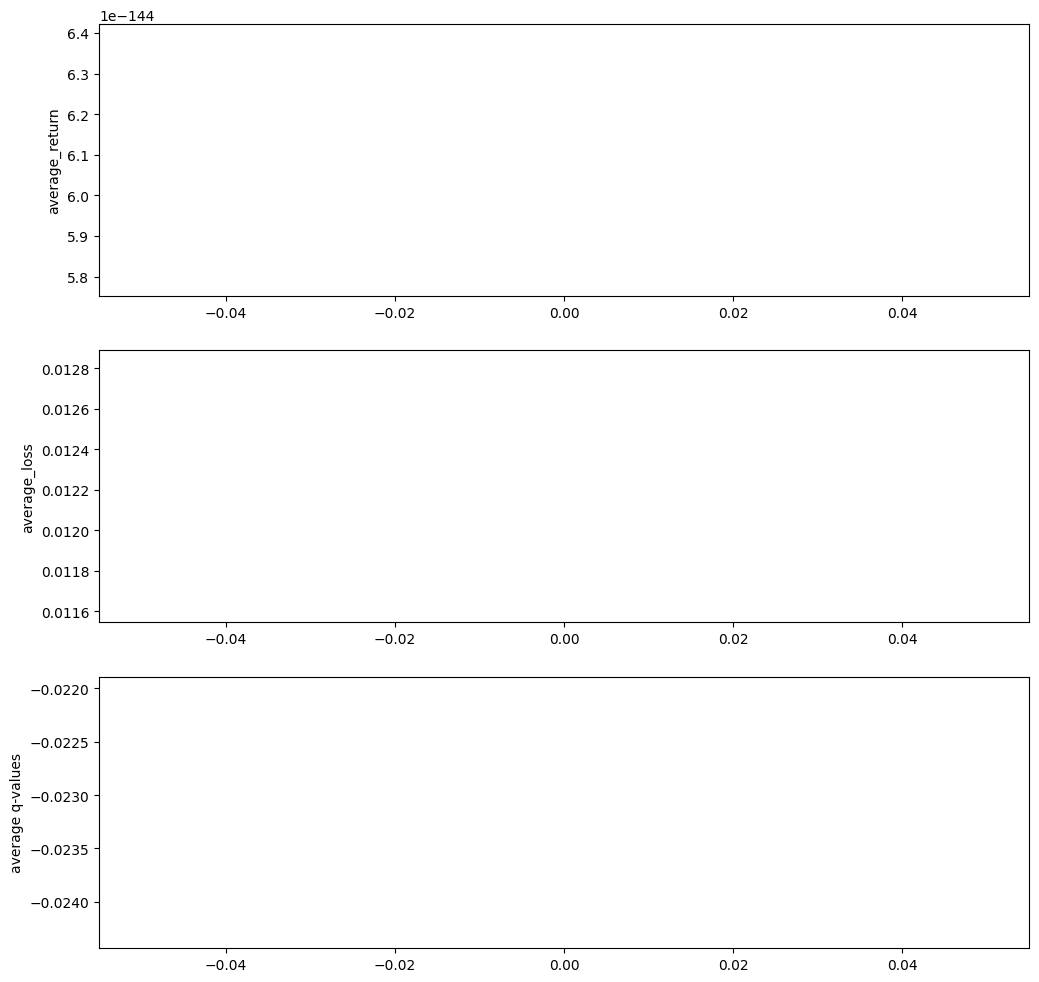

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
Training step:  1
Training step:  2


Training step:  3
Training step:  4
Training step:  5
Training step:  6
Training step:  7
Training step:  8
Training step:  9
Training step:  10
Training step:  11
Training step:  12
Training step:  13
Training step:  14
Training step:  15
Training step:  16
Training step:  17
Training step:  18
Training step:  19
Training step:  20
Training step:  21
Training step:  22
Training step:  23
Training step:  24
Training step:  25
Training step:  26
Training step:  27
Training step:  28
Training step:  29
Training step:  30
Training step:  31
Training step:  32
Training step:  33
Training step:  34
Training step:  35
Training step:  36
Training step:  37
Training step:  38
Training step:  39
Training step:  40
Training step:  41
Training step:  42
Training step:  43
Training step:  44
Training step:  45
Training step:  46
Training step:  47
Training step:  48
Training step:  49
Training step:  50
TESTING: Average return: 4.3645072724480946e-61, Average loss: 0.009893941693007946, Average q-

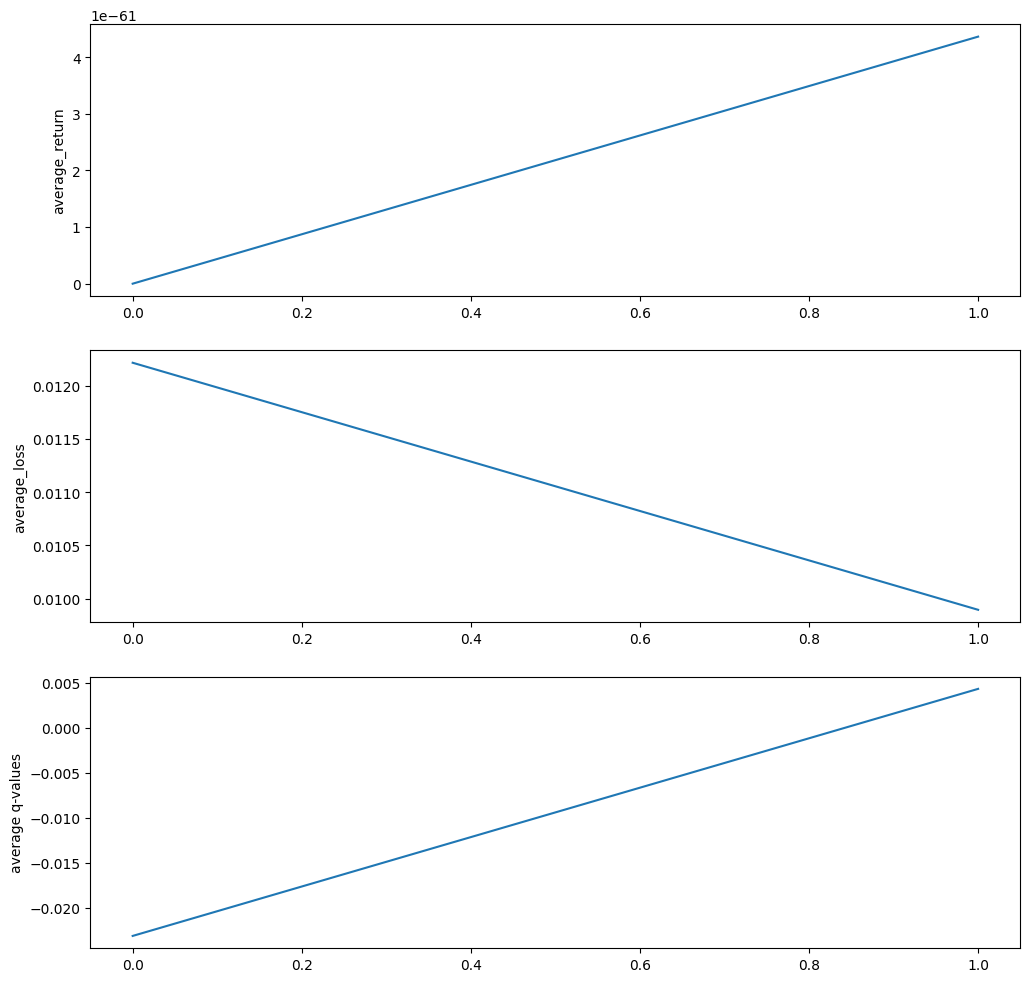

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
Training step:  51
Training step:  52
Training step:  53
Training step:  54
Training step:  55
Training step:  56
Training step:  57
Training step:  58
Training step:  59
Training step:  60
Training step:  61
Training step:  62
Training step:  63
Training step:  64
Training step:  65
Training step:  66
Training step:  67
Training step:  68
Training step:  69
Training step:  70
Training step:  71
Training step:  72
Training step:  73
Training step:  74
Training step:  75
Training step:  76
Training step:  77
Training step:  78
Training step:  79
Training step:  80
Training step:  81
Training step:  82
Training step:  83
Training step:  84
Training step:  85
Training step:  86
Training step:  87
Training step:  88
Training step:  89
Training step:  90
Training step:  91
Training step:  92
Training step:  93
Training step:  94
Training step:

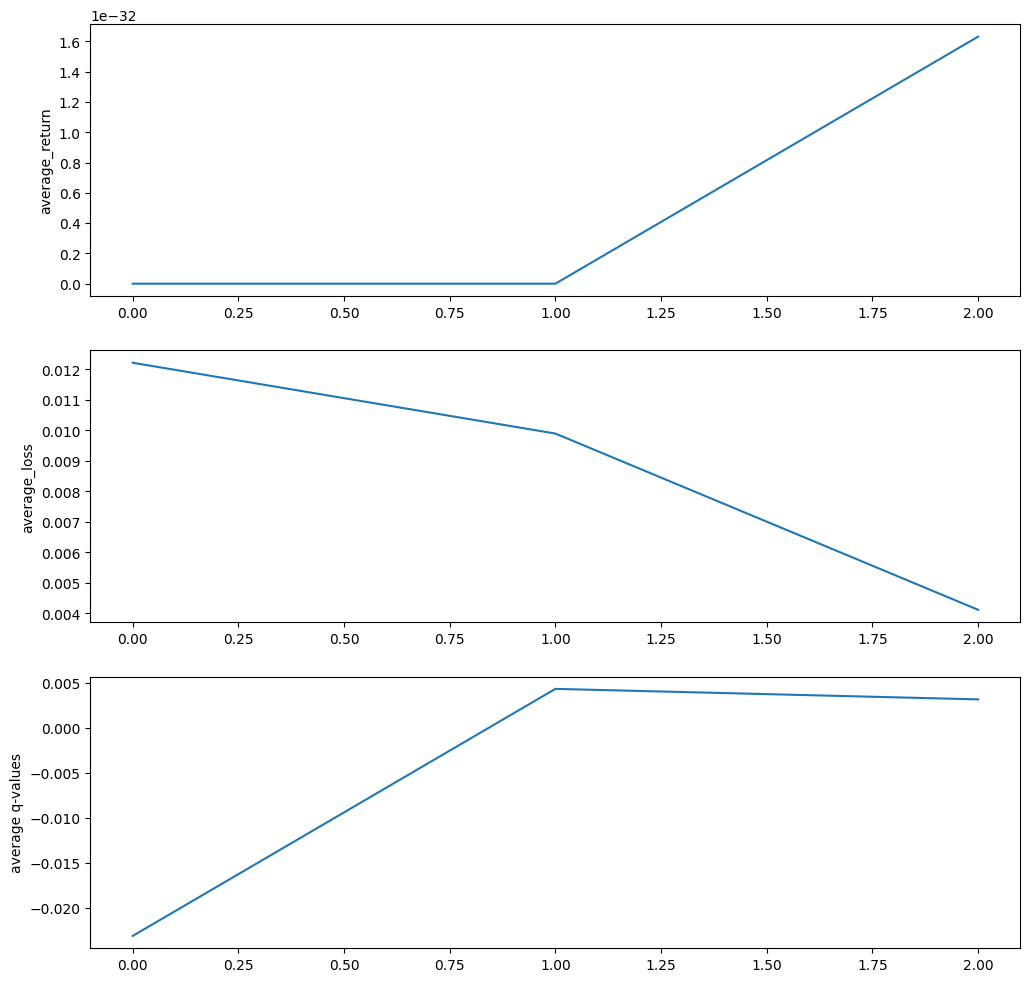

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
Training step:  101
Training step:  102
Training step:  103
Training step:  104
Training step:  105
Training step:  106
Training step:  107
Training step:  108
Training step:  109
Training step:  110
Training step:  111
Training step:  112
Training step:  113
Training step:  114
Training step:  115
Training step:  116
Training step:  117
Training step:  118
Training step:  119
Training step:  120
Training step:  121
Training step:  122
Training step:  123
Training step:  124
Training step:  125
Training step:  126
Training step:  127
Training step:  128
Training step:  129
Training step:  130
Training step:  131
Training step:  132
Training step:  133
Training step:  134
Training step:  135
Training step:  136
Training step:  137
Training step:  138
Training step:  139
Training step:  140


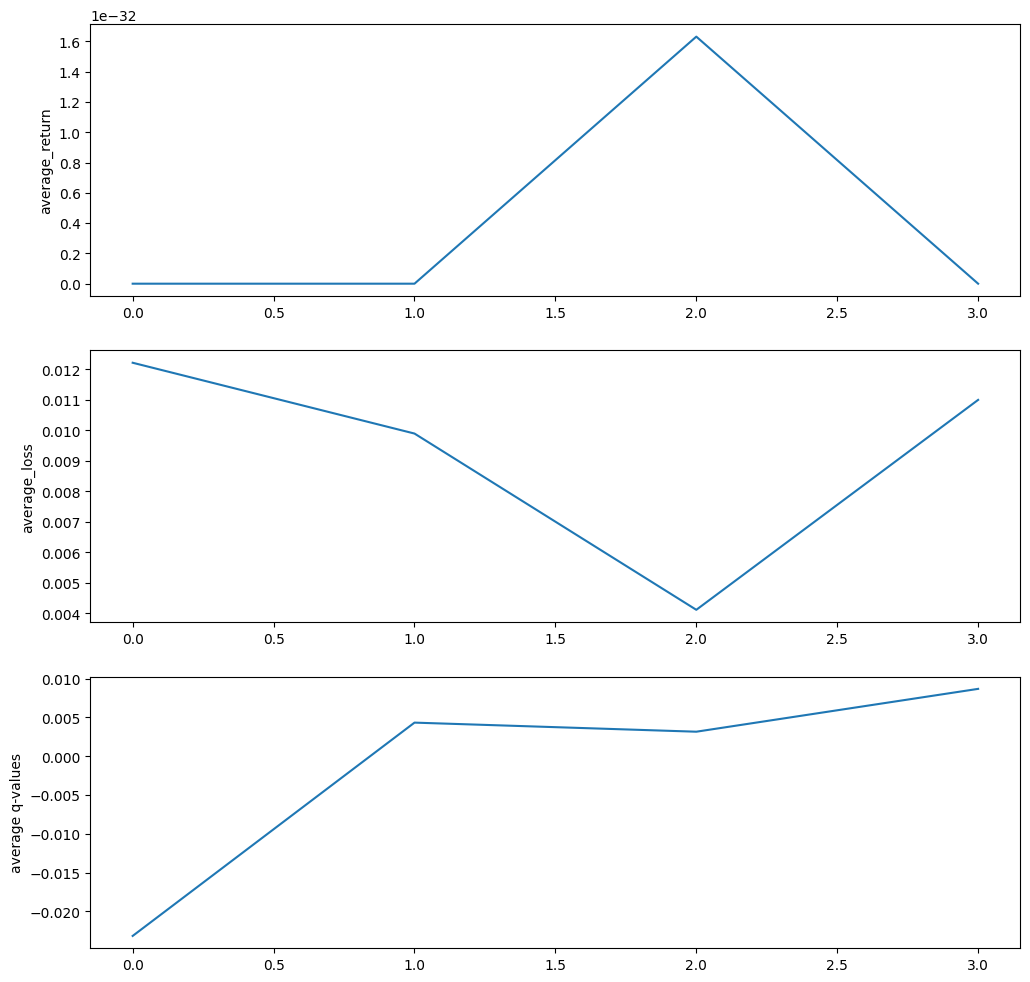

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
3    1.651537e-83      0.010999          0.008684
Training step:  151
Training step:  152
Training step:  153
Training step:  154
Training step:  155
Training step:  156
Training step:  157
Training step:  158
Training step:  159
Training step:  160
Training step:  161
Training step:  162
Training step:  163
Training step:  164
Training step:  165
Training step:  166
Training step:  167
Training step:  168
Training step:  169
Training step:  170
Training step:  171
Training step:  172
Training step:  173
Training step:  174
Training step:  175
Training step:  176
Training step:  177
Training step:  178
Training step:  179
Training step:  180
Training step:  181
Training step:  182
Training step:  183
Training step:  184
Training step:  185
Training step:  186
Training step:  187
Training s

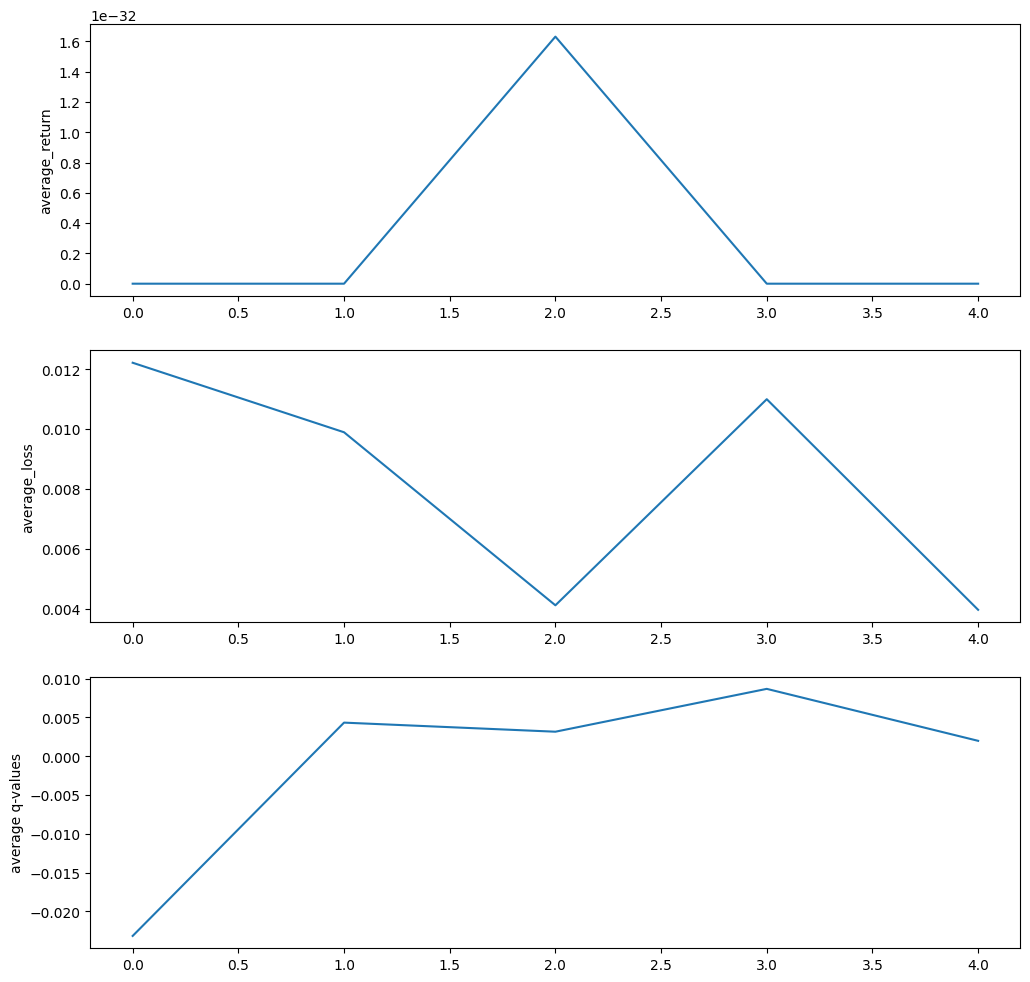

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
3    1.651537e-83      0.010999          0.008684
4   4.530050e-201      0.003960          0.001986
Training step:  201
Training step:  202
Training step:  203
Training step:  204
Training step:  205
Training step:  206
Training step:  207
Training step:  208
Training step:  209
Training step:  210
Training step:  211
Training step:  212
Training step:  213
Training step:  214
Training step:  215
Training step:  216
Training step:  217
Training step:  218
Training step:  219
Training step:  220
Training step:  221
Training step:  222
Training step:  223
Training step:  224
Training step:  225
Training step:  226
Training step:  227
Training step:  228
Training step:  229
Training step:  230
Training step:  231
Training step:  232
Training step:  233
Training step:  234
Training step:  235


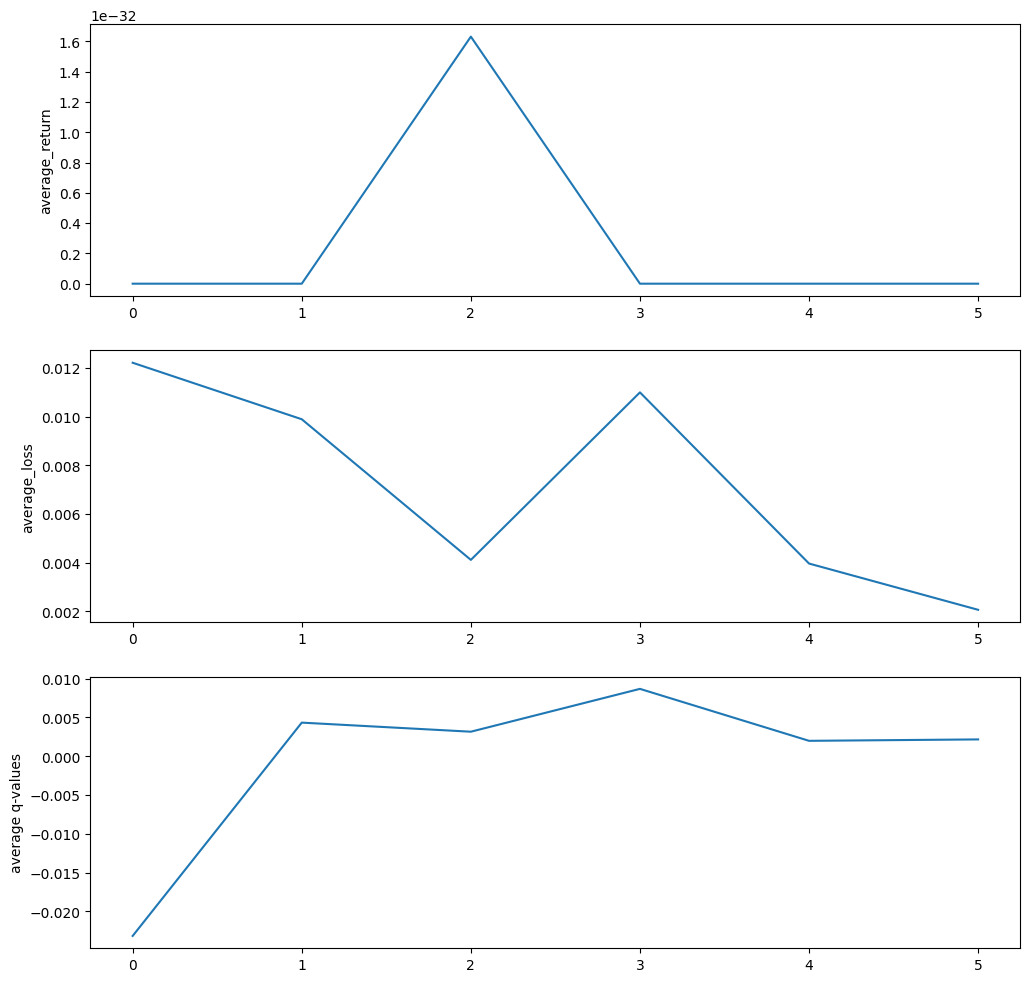

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
3    1.651537e-83      0.010999          0.008684
4   4.530050e-201      0.003960          0.001986
5   9.805777e-137      0.002057          0.002168
Training step:  251
Training step:  252
Training step:  253
Training step:  254
Training step:  255
Training step:  256
Training step:  257
Training step:  258
Training step:  259
Training step:  260
Training step:  261
Training step:  262
Training step:  263
Training step:  264
Training step:  265
Training step:  266
Training step:  267
Training step:  268
Training step:  269
Training step:  270
Training step:  271
Training step:  272
Training step:  273
Training step:  274
Training step:  275
Training step:  276
Training step:  277
Training step:  278
Training step:  279
Training step:  280
Training step:  281
Training step:  282
Training s

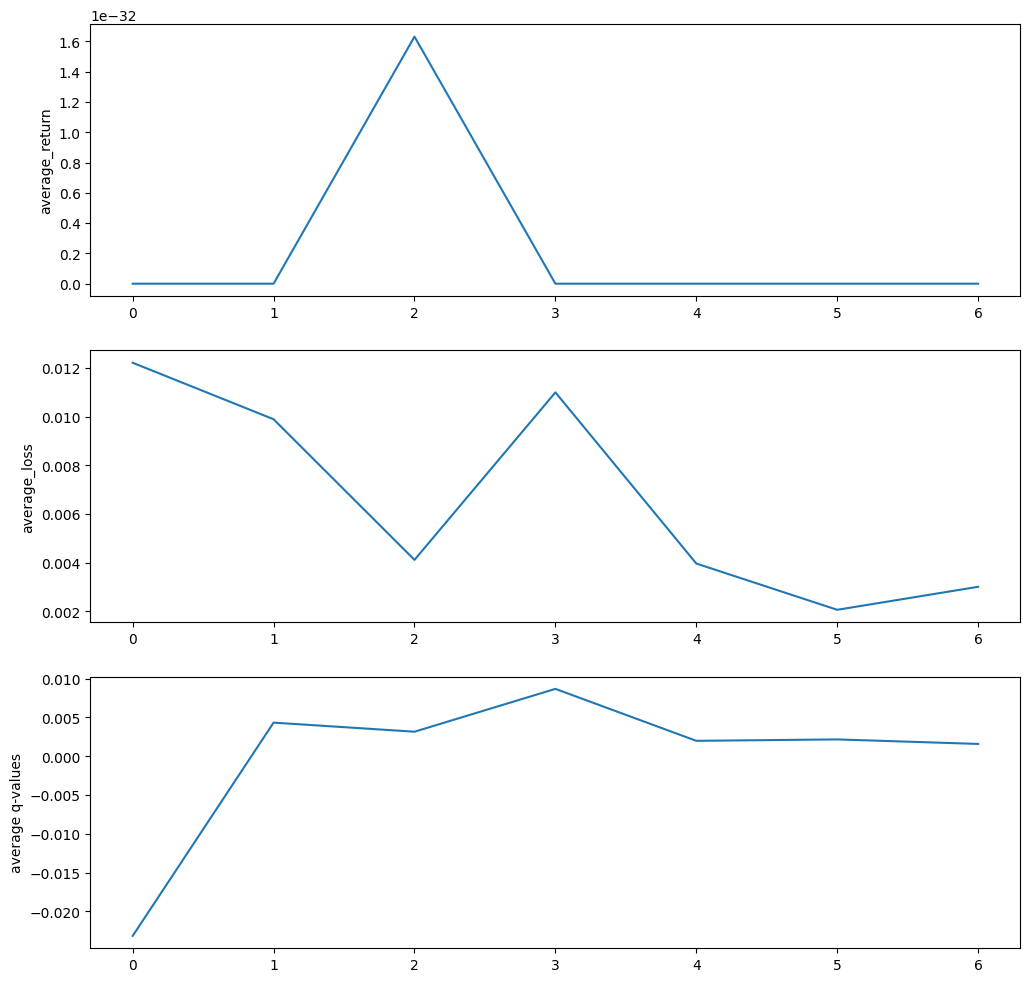

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
3    1.651537e-83      0.010999          0.008684
4   4.530050e-201      0.003960          0.001986
5   9.805777e-137      0.002057          0.002168
6   4.871878e-221      0.003004          0.001586
Training step:  301
Training step:  302
Training step:  303
Training step:  304
Training step:  305
Training step:  306
Training step:  307
Training step:  308
Training step:  309
Training step:  310
Training step:  311
Training step:  312
Training step:  313
Training step:  314
Training step:  315
Training step:  316
Training step:  317
Training step:  318
Training step:  319
Training step:  320
Training step:  321
Training step:  322
Training step:  323
Training step:  324
Training step:  325
Training step:  326
Training step:  327
Training step:  328
Training step:  329
Training step:  330


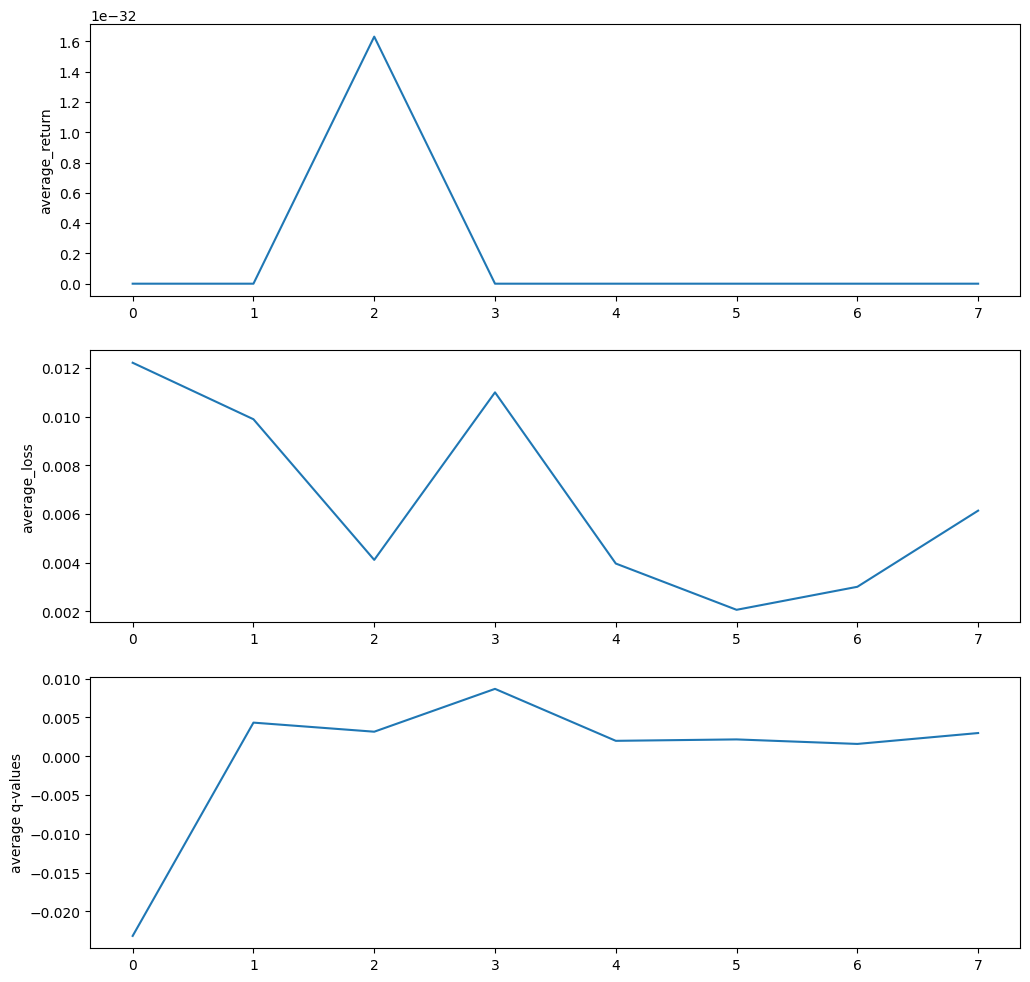

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
3    1.651537e-83      0.010999          0.008684
4   4.530050e-201      0.003960          0.001986
5   9.805777e-137      0.002057          0.002168
6   4.871878e-221      0.003004          0.001586
7   1.452319e-304      0.006135          0.002990
Training step:  351
Training step:  352
Training step:  353
Training step:  354
Training step:  355
Training step:  356
Training step:  357
Training step:  358
Training step:  359
Training step:  360
Training step:  361
Training step:  362
Training step:  363
Training step:  364
Training step:  365
Training step:  366
Training step:  367
Training step:  368
Training step:  369
Training step:  370
Training step:  371
Training step:  372
Training step:  373
Training step:  374
Training step:  375
Training step:  376
Training step:  377
Training s

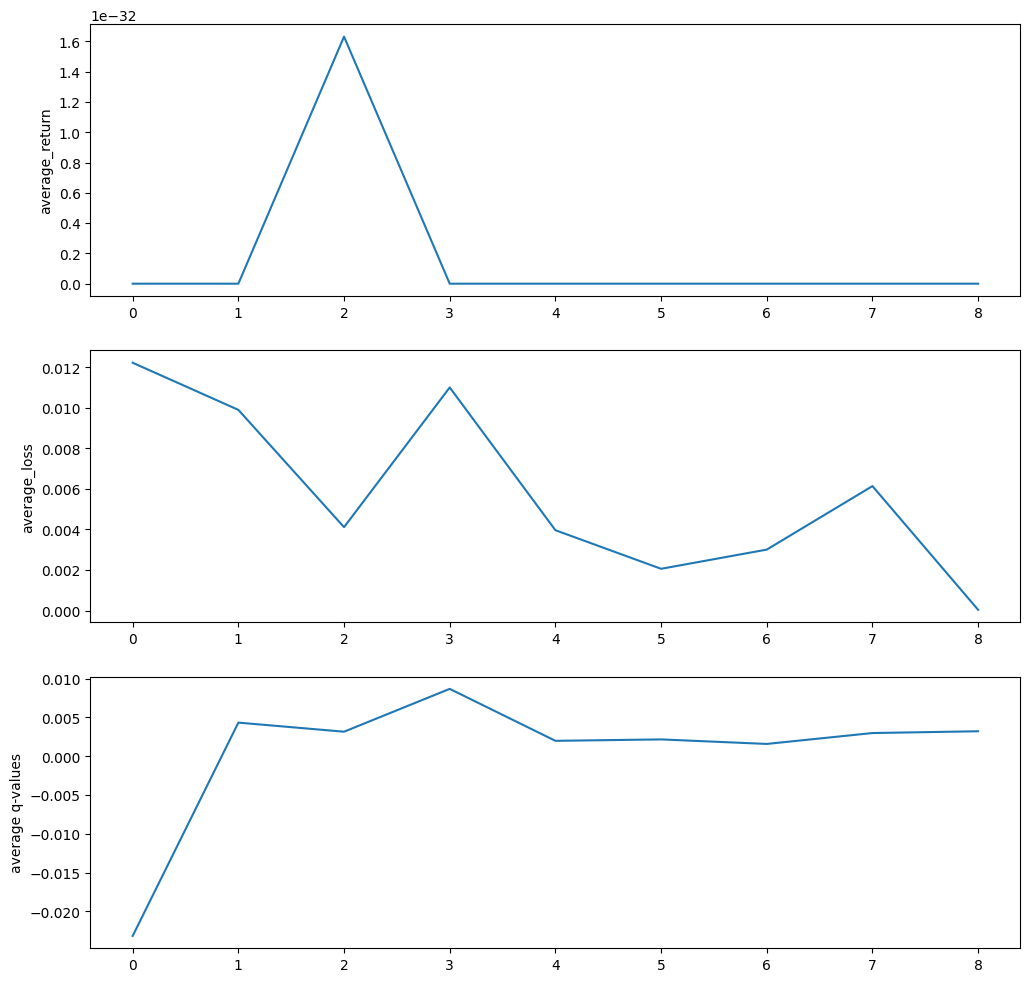

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
3    1.651537e-83      0.010999          0.008684
4   4.530050e-201      0.003960          0.001986
5   9.805777e-137      0.002057          0.002168
6   4.871878e-221      0.003004          0.001586
7   1.452319e-304      0.006135          0.002990
8    3.056365e-71      0.000035          0.003219
Training step:  401
Training step:  402
Training step:  403
Training step:  404
Training step:  405
Training step:  406
Training step:  407
Training step:  408
Training step:  409
Training step:  410
Training step:  411
Training step:  412
Training step:  413
Training step:  414
Training step:  415
Training step:  416
Training step:  417
Training step:  418
Training step:  419
Training step:  420
Training step:  421
Training step:  422
Training step:  423
Training step:  424
Training step:  425


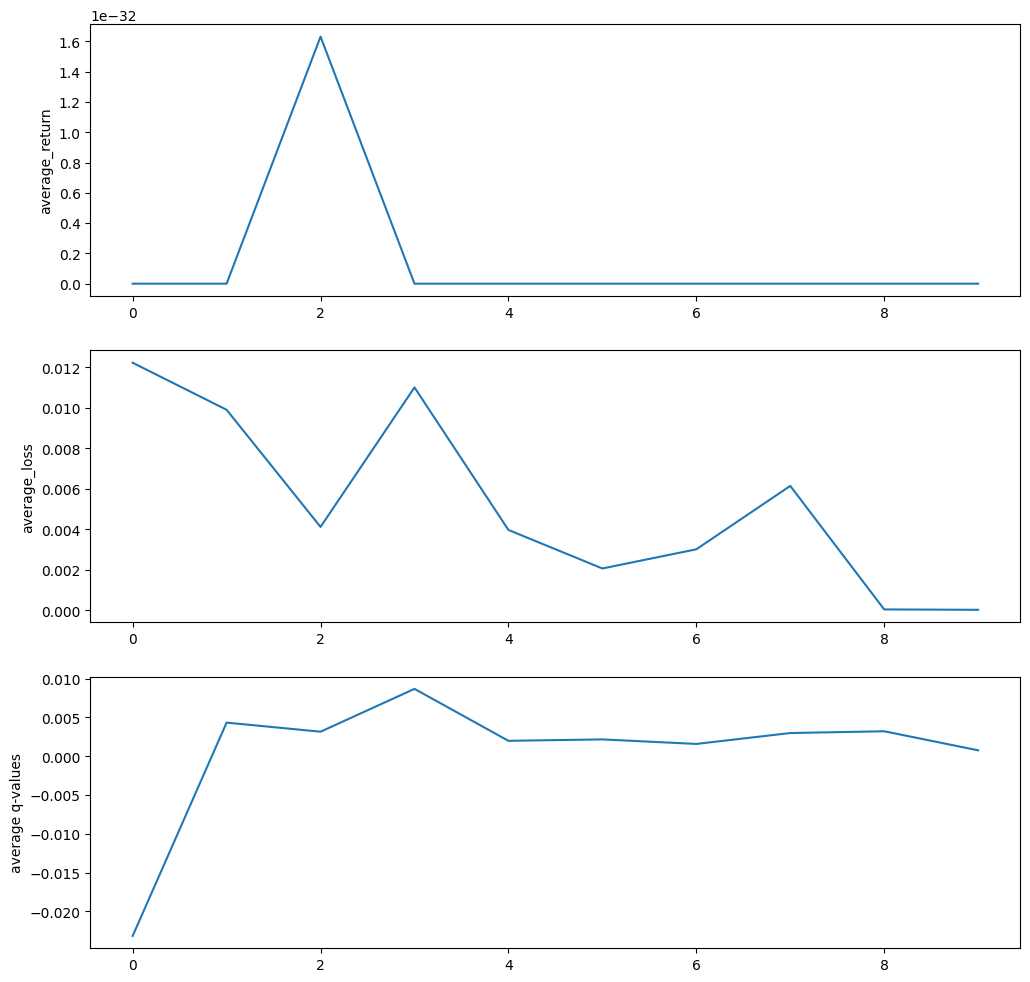

   average_return  average_loss  average q-values
0   6.086880e-144      0.012217         -0.023162
1    4.364507e-61      0.009894          0.004333
2    1.631255e-32      0.004110          0.003162
3    1.651537e-83      0.010999          0.008684
4   4.530050e-201      0.003960          0.001986
5   9.805777e-137      0.002057          0.002168
6   4.871878e-221      0.003004          0.001586
7   1.452319e-304      0.006135          0.002990
8    3.056365e-71      0.000035          0.003219
9    1.619894e-51      0.000016          0.000762
Training step:  451
Training step:  452
Training step:  453
Training step:  454
Training step:  455
Training step:  456
Training step:  457
Training step:  458
Training step:  459
Training step:  460
Training step:  461
Training step:  462
Training step:  463
Training step:  464
Training step:  465
Training step:  466
Training step:  467
Training step:  468
Training step:  469
Training step:  470
Training step:  471
Training step:  472
Training s

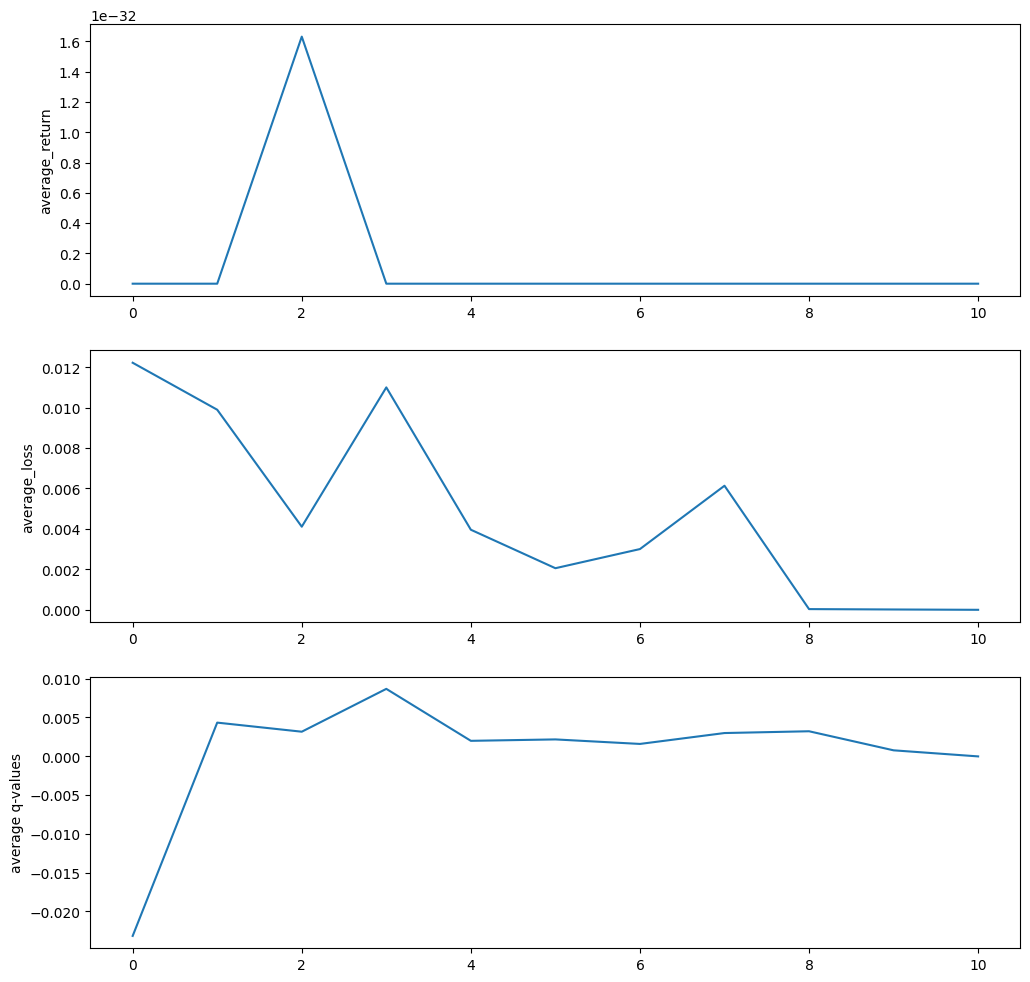

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
Training step:  501
Training step:  502
Training step:  503
Training step:  504
Training step:  505
Training step:  506
Training step:  507
Training step:  508
Training step:  509
Training step:  510
Training step:  511
Training step:  512
Training step:  513
Training step:  514
Training step:  515
Training step:  516
Training step:  517
Training step:  518
Training step:  519
Training

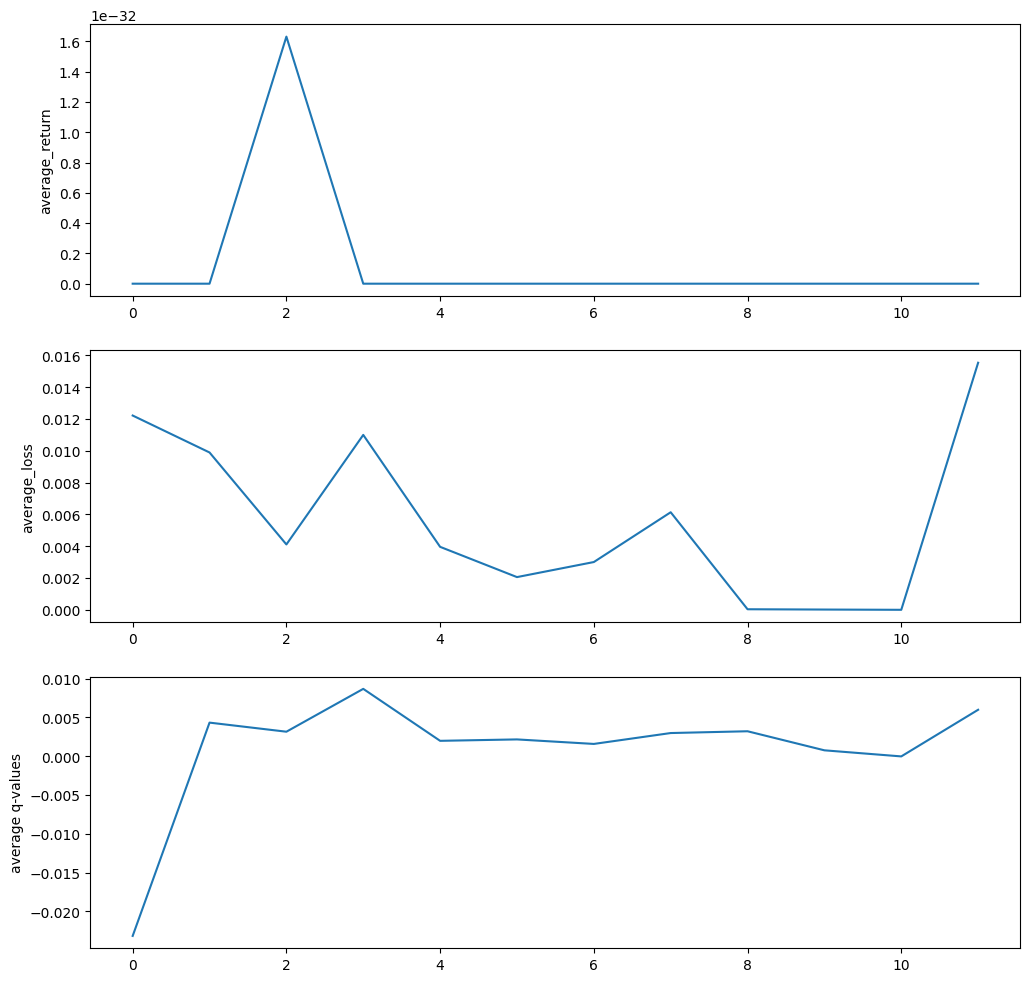

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
Training step:  551
Training step:  552
Training step:  553
Training step:  554
Training step:  555
Training step:  556
Training step:  557
Training step:  558
Training step:  559
Training step:  560
Training step:  561
Training step:  562
Training step:  563
Training step:  564
Training step:  565
Training step:  566
Training step:  5

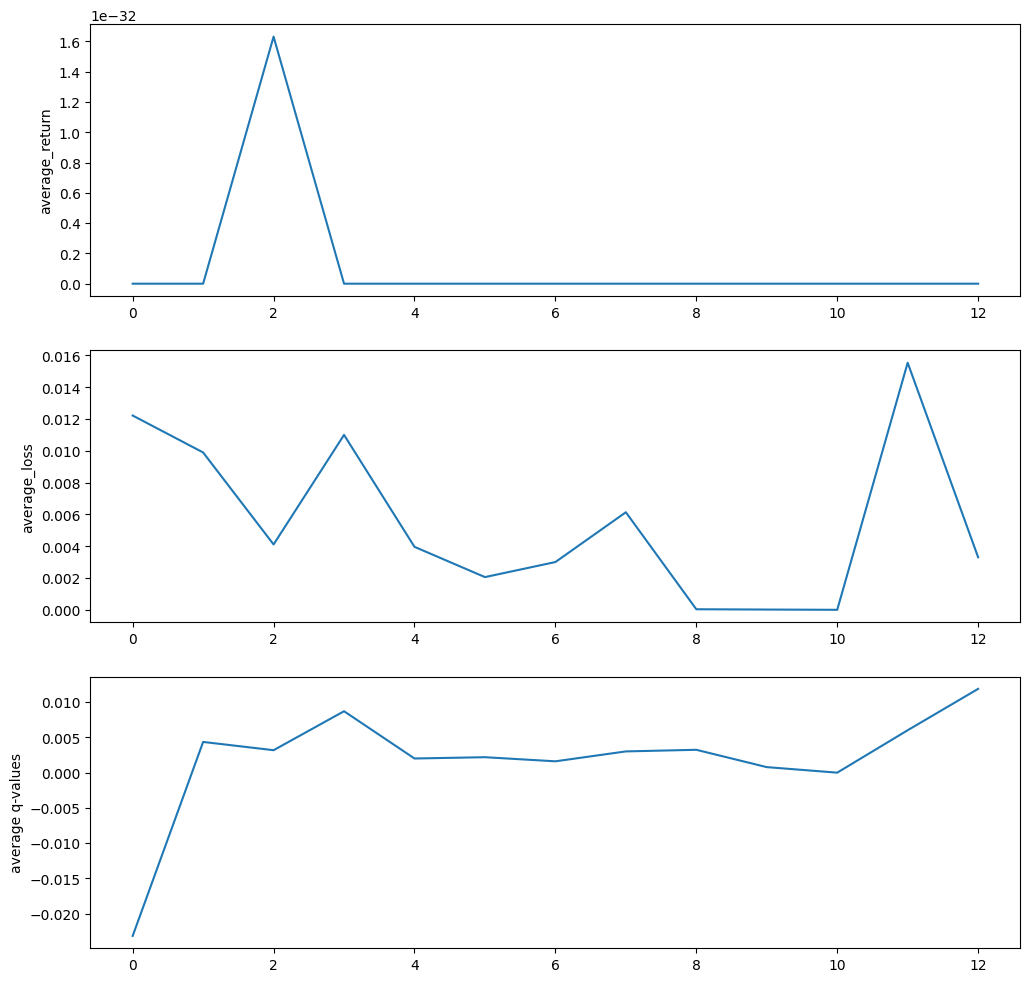

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
Training step:  601
Training step:  602
Training step:  603
Training step:  604
Training step:  605
Training step:  606
Training step:  607
Training step:  608
Training step:  609
Training step:  610
Training step:  611
Training step:  612
Training step:  613
Training step:  614
Traini

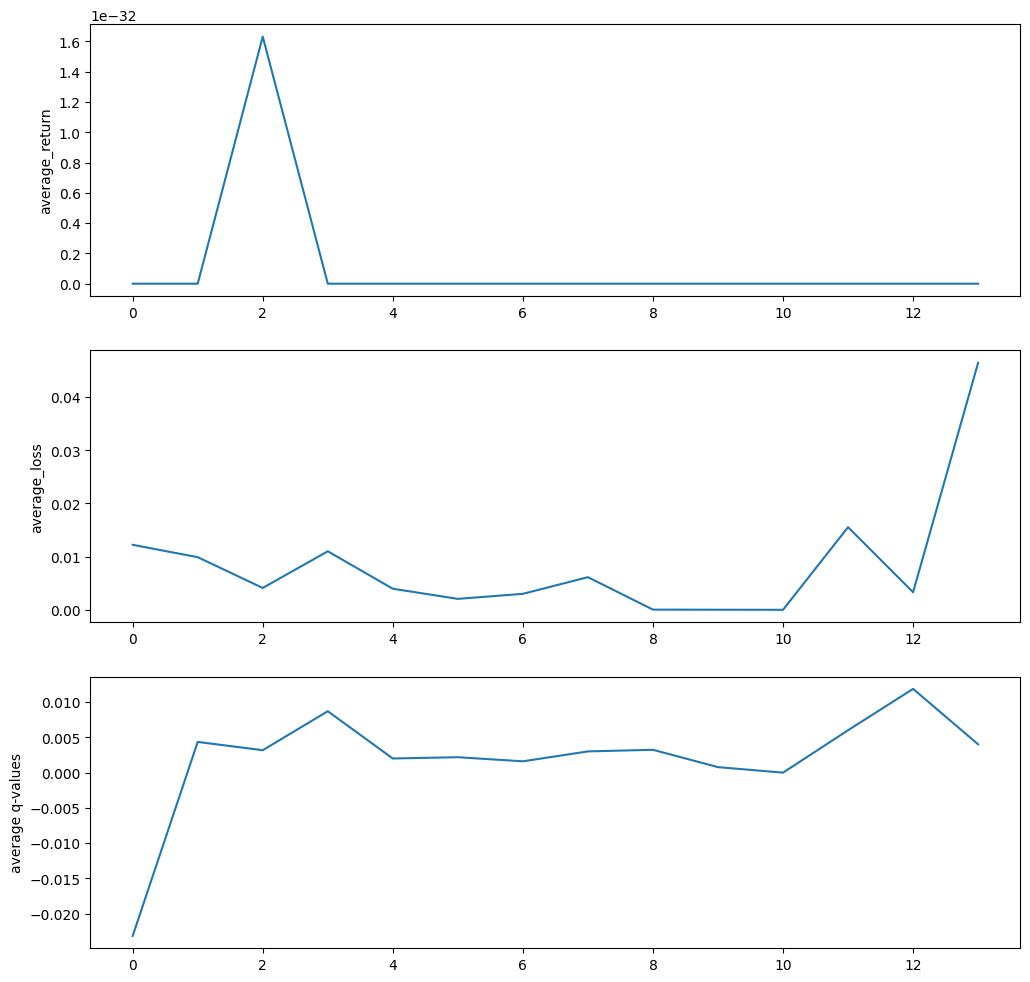

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
Training step:  651
Training step:  652
Training step:  653
Training step:  654
Training step:  655
Training step:  656
Training step:  657
Training step:  658
Training step:  659
Training step:  660
Training step:  661
Training step: 

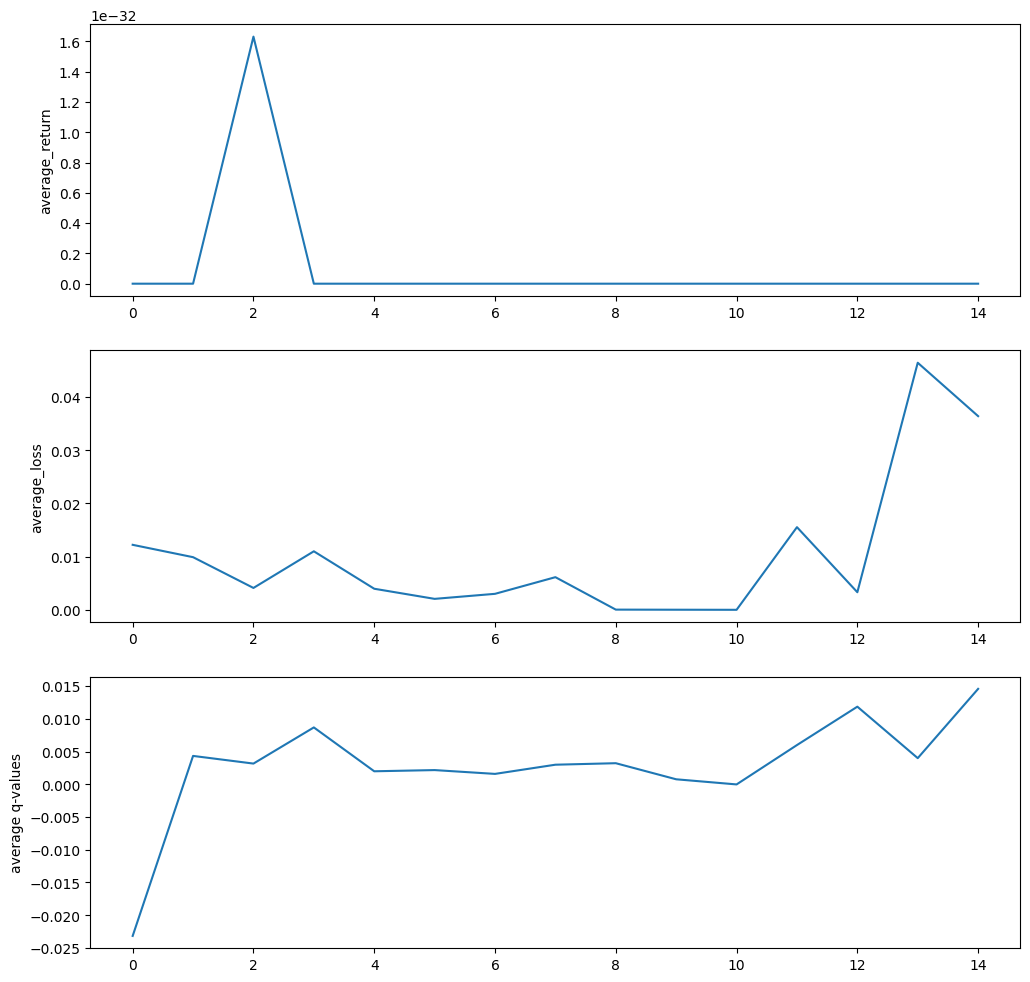

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
Training step:  701
Training step:  702
Training step:  703
Training step:  704
Training step:  705
Training step:  706
Training step:  707
Training step:  708
Training step:  709
Trai

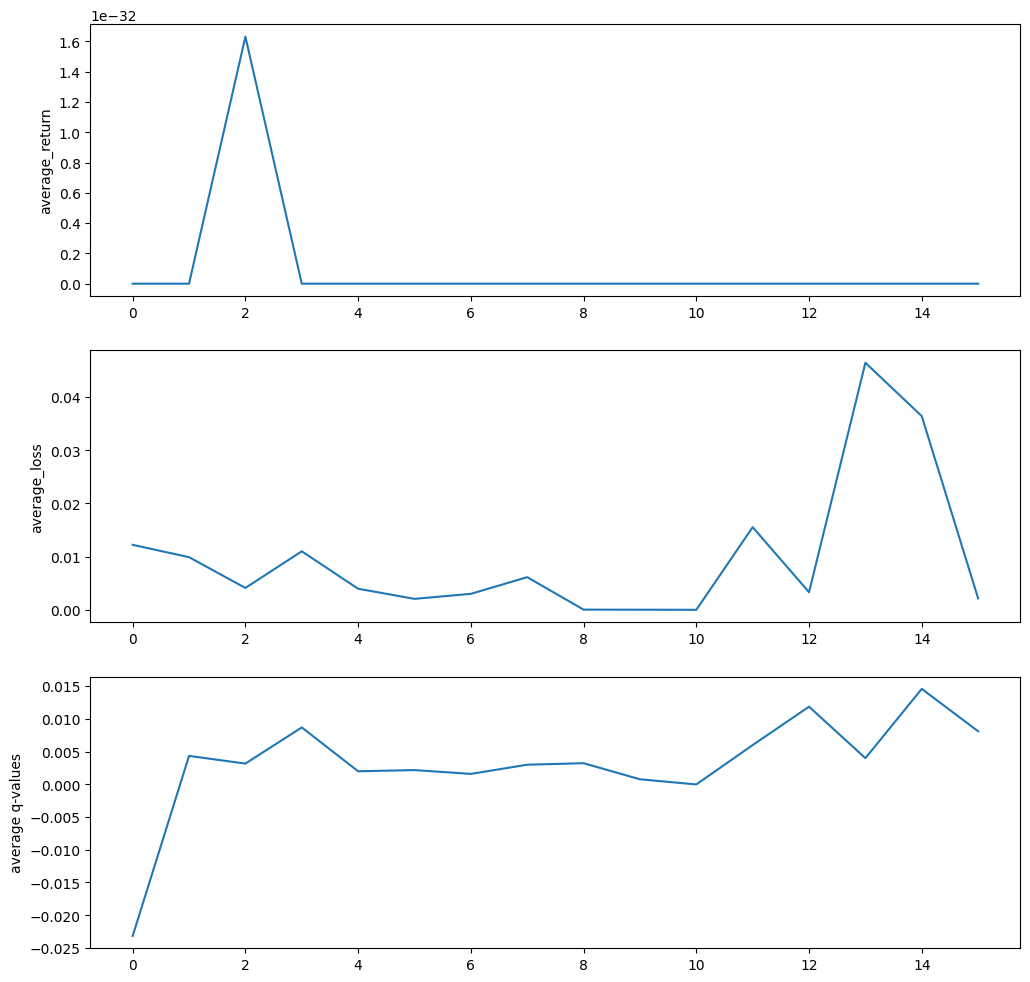

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
Training step:  751
Training step:  752
Training step:  753
Training step:  754
Training step:  755
Training step:  756
Training step

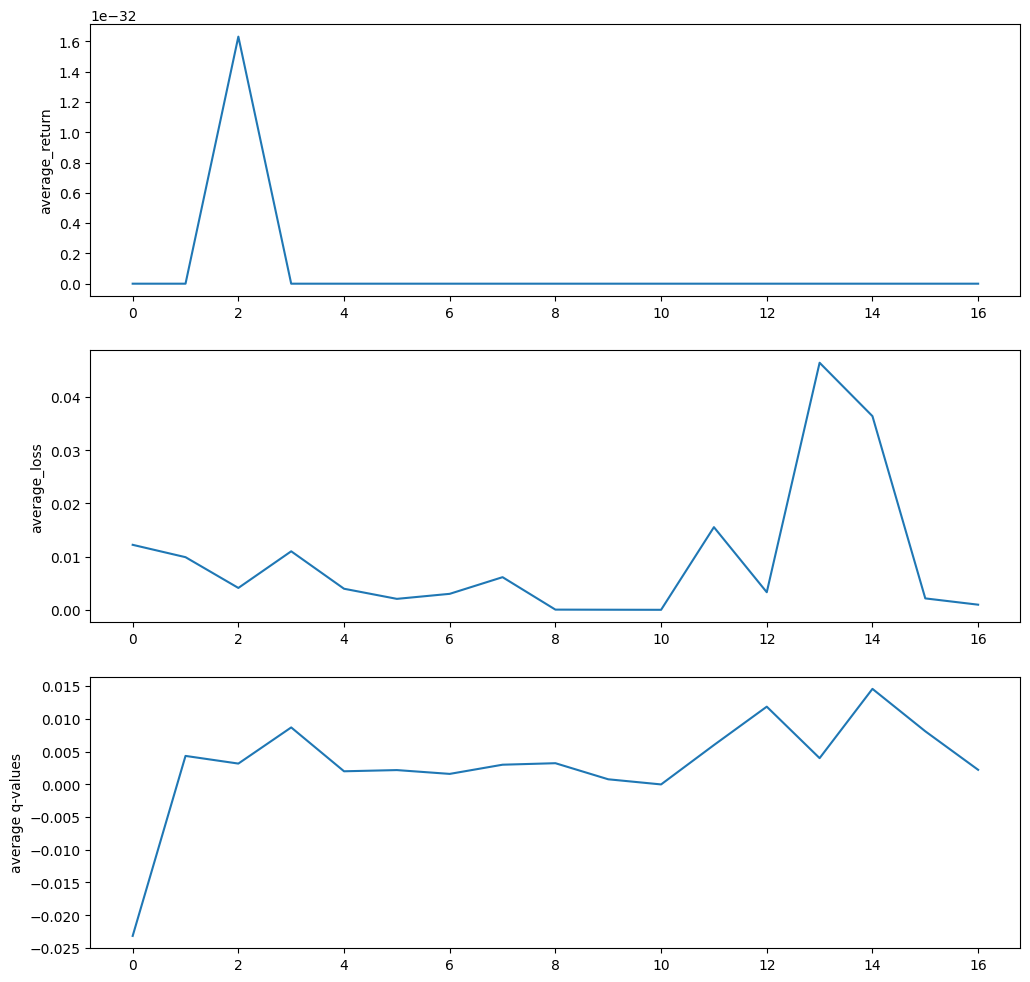

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
Training step:  801
Training step:  802
Training step:  803
Training step:  804
Tr

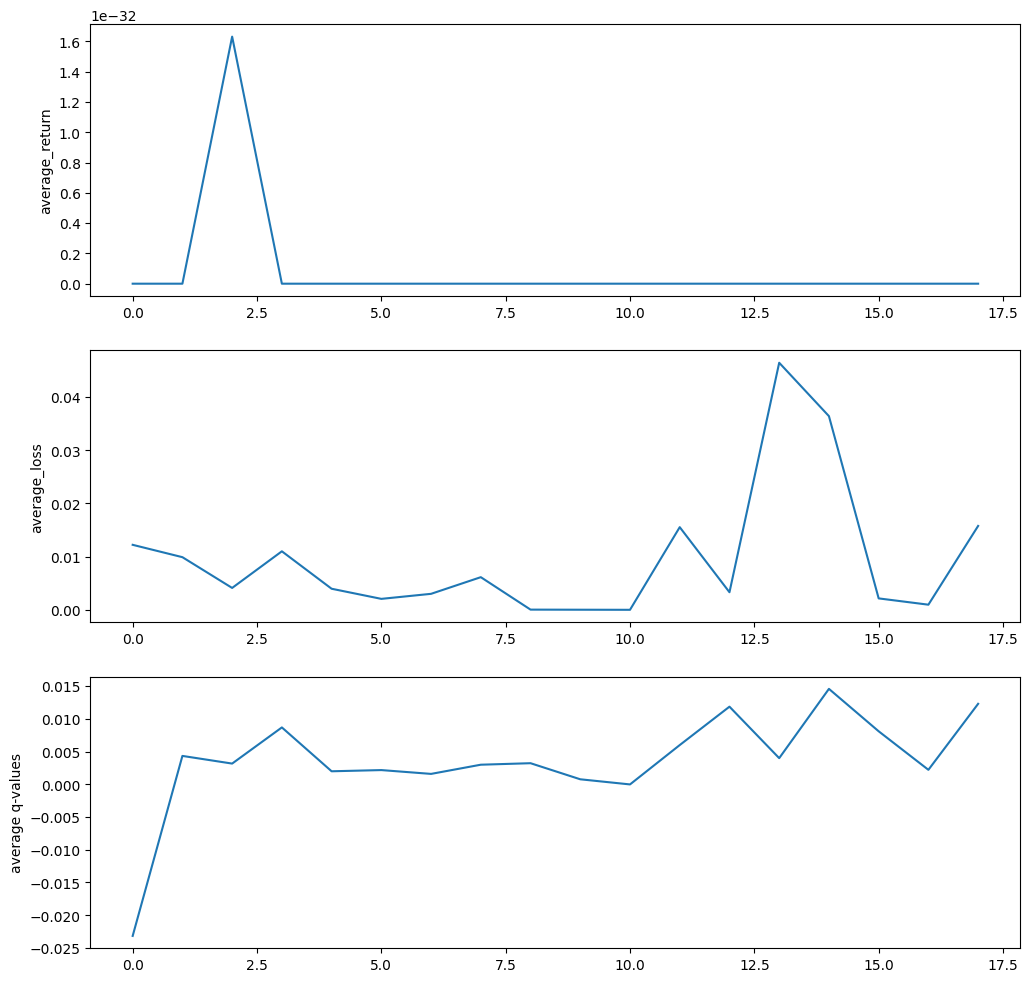

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
Training step:  851
Training st

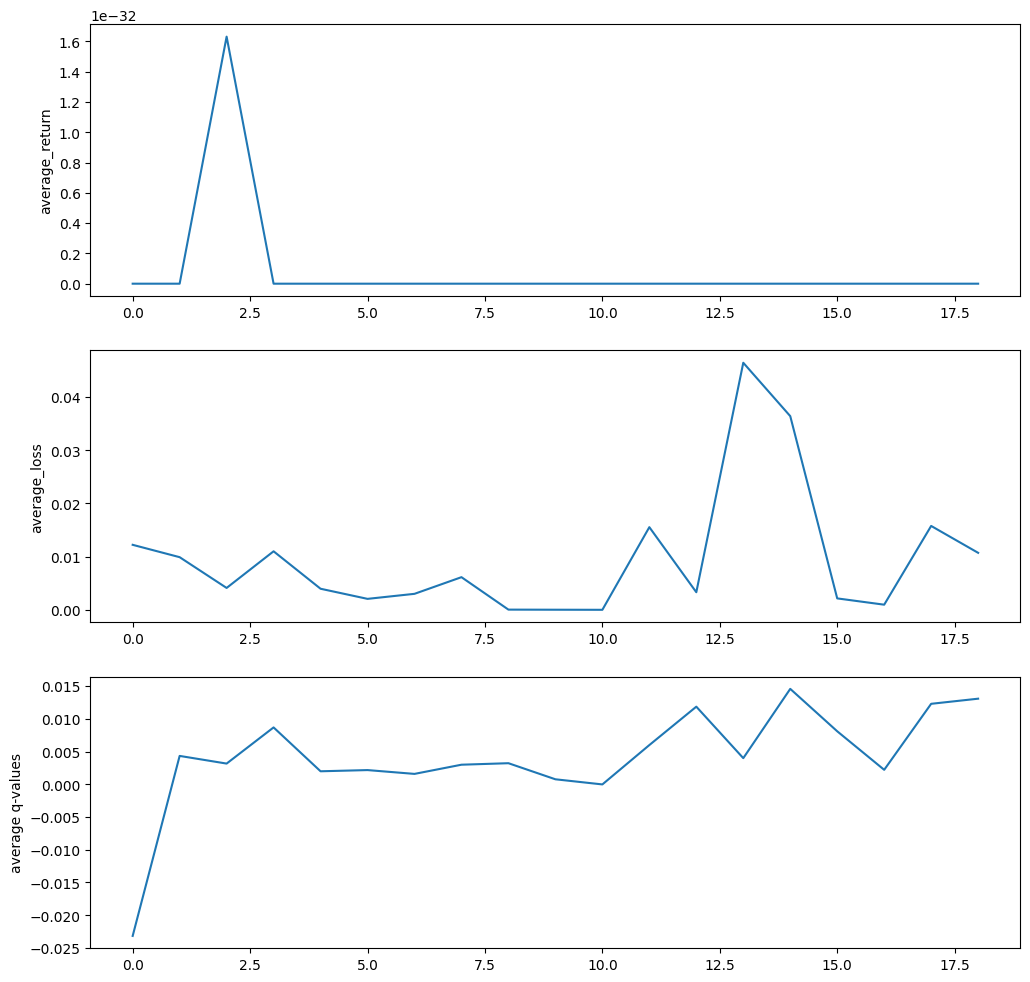

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

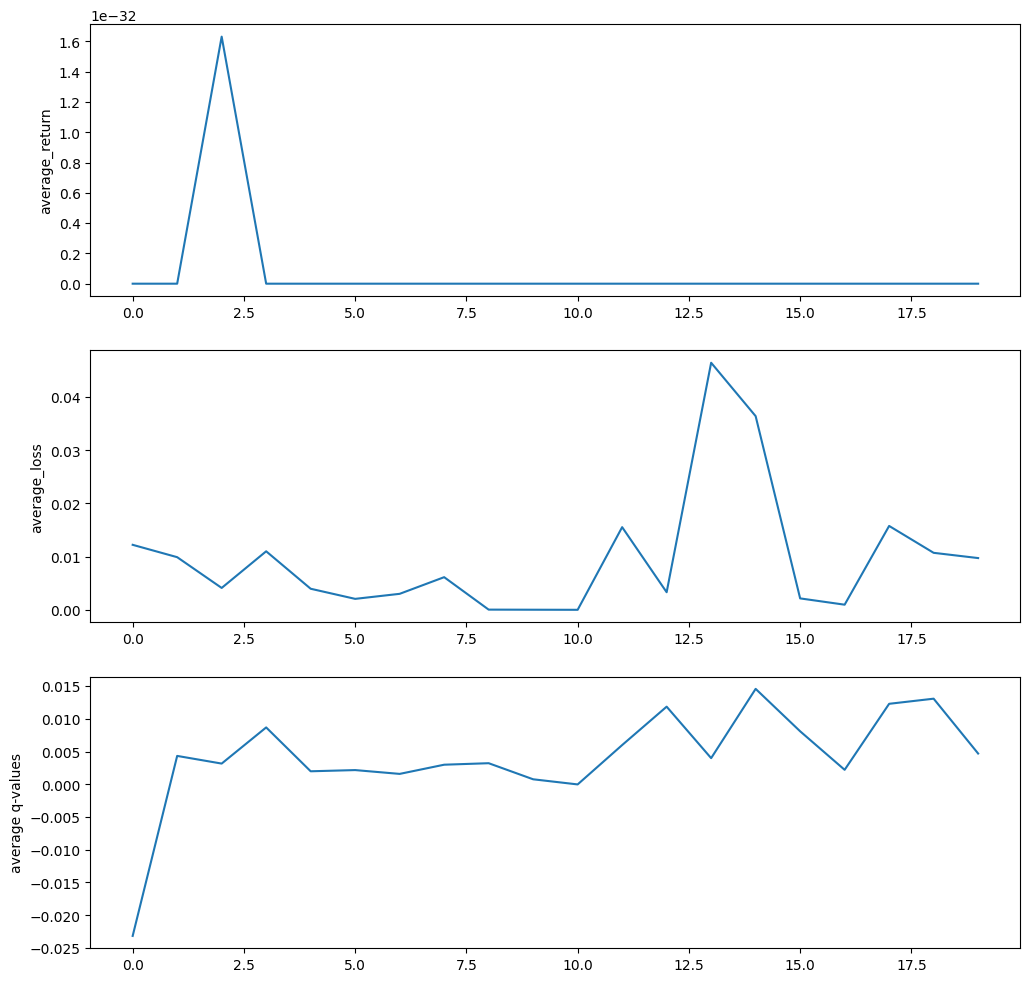

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

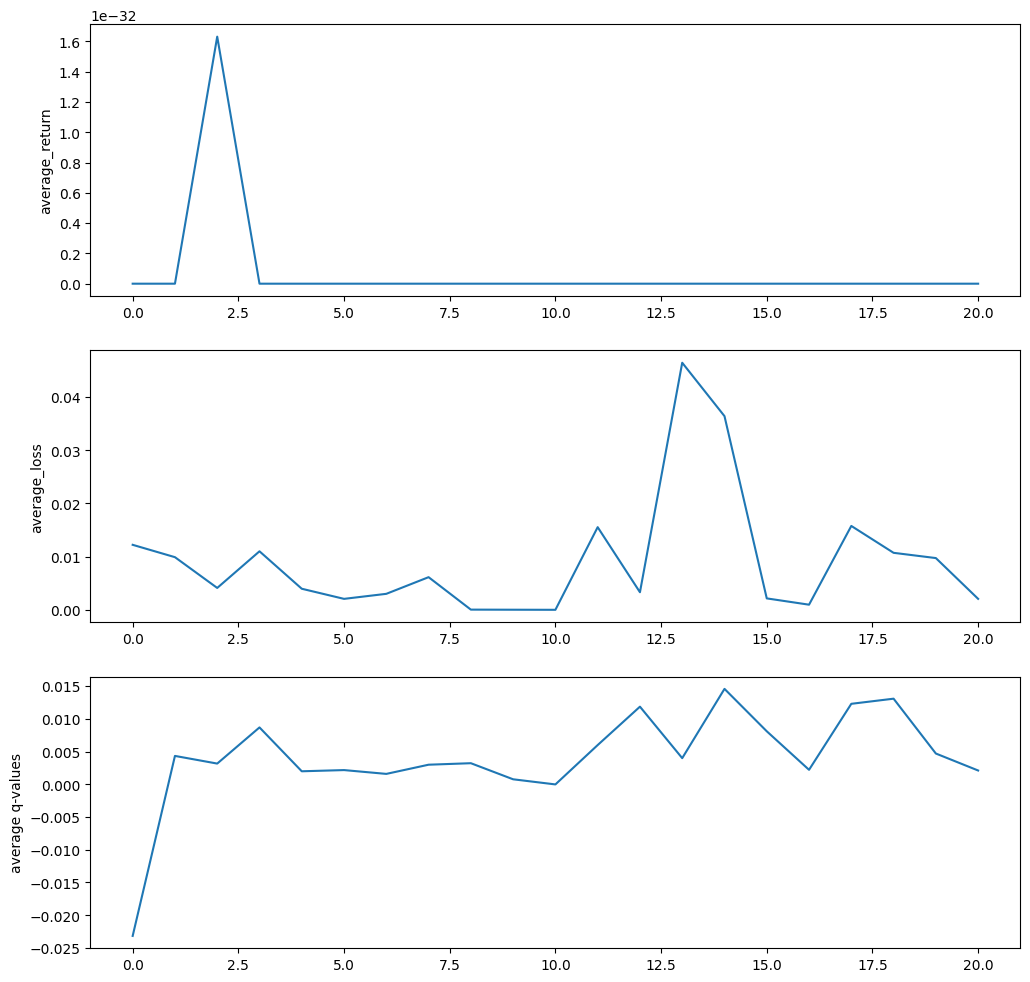

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

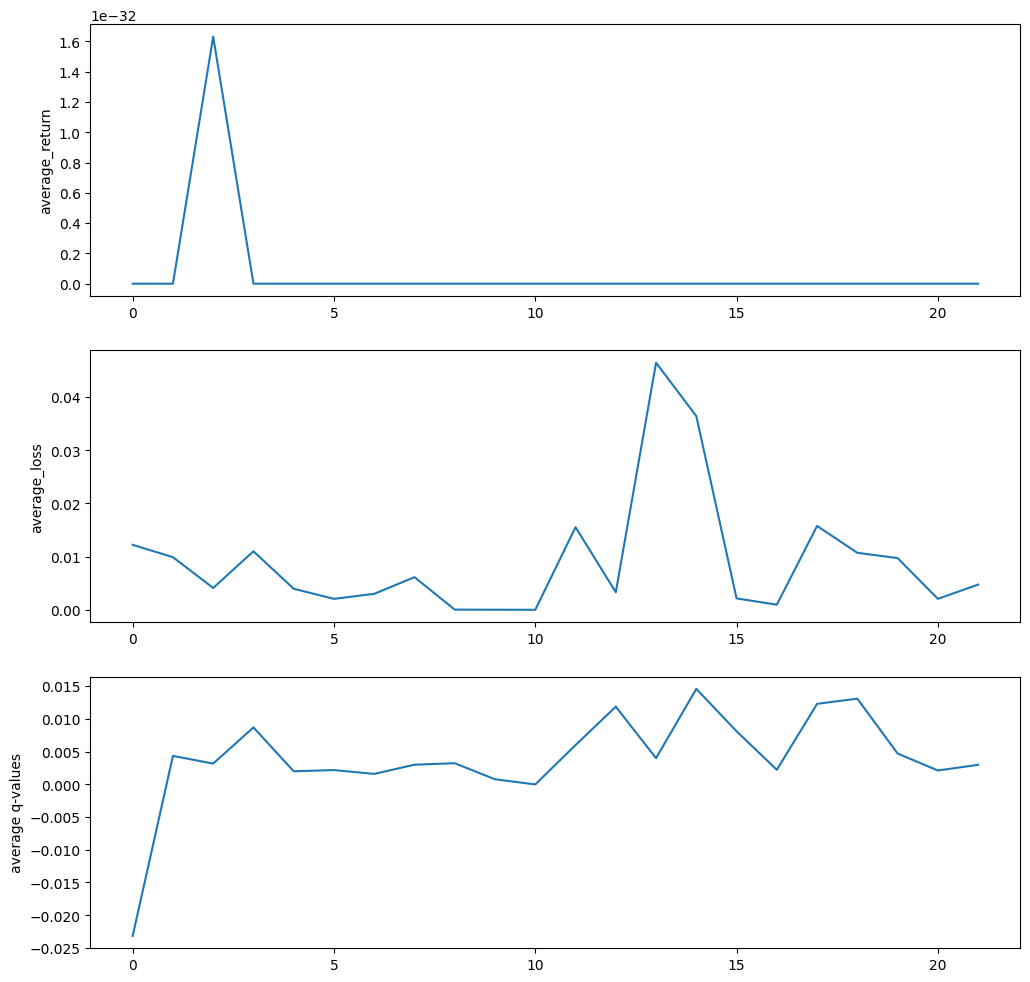

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

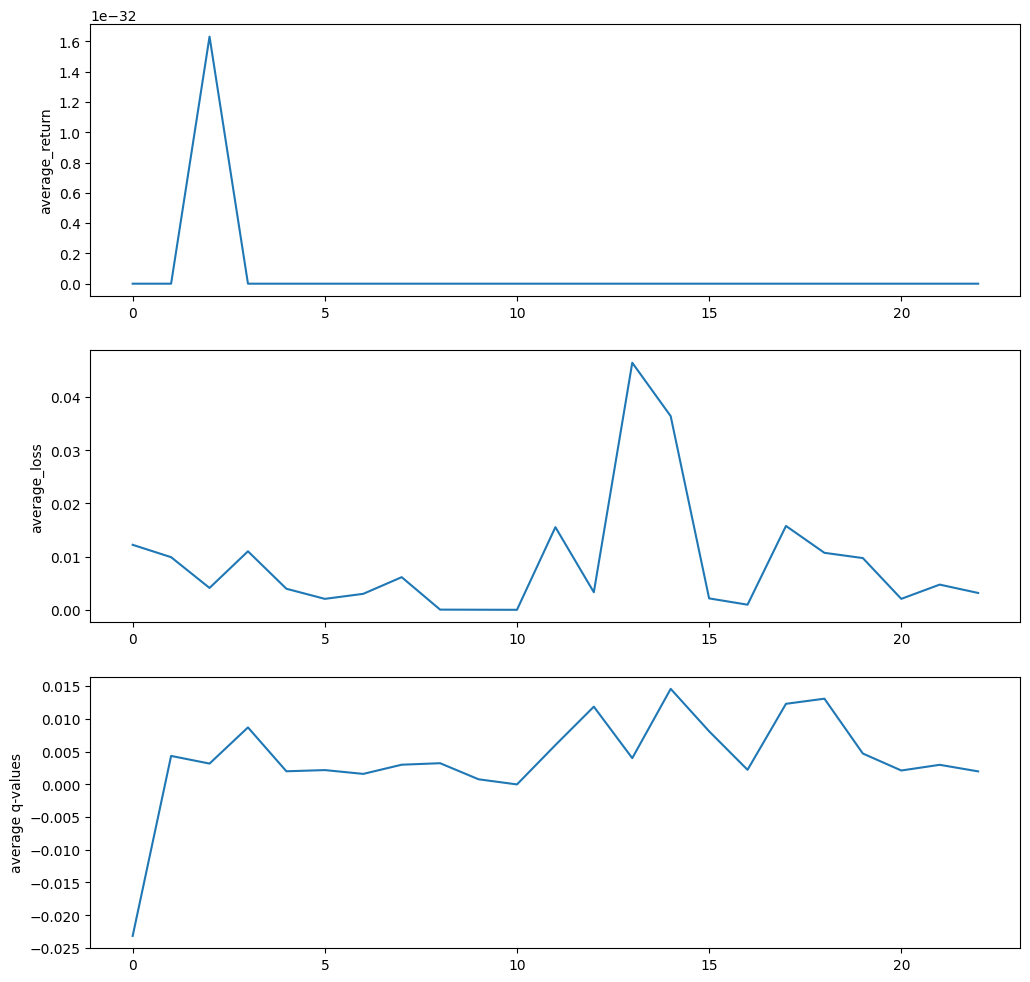

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

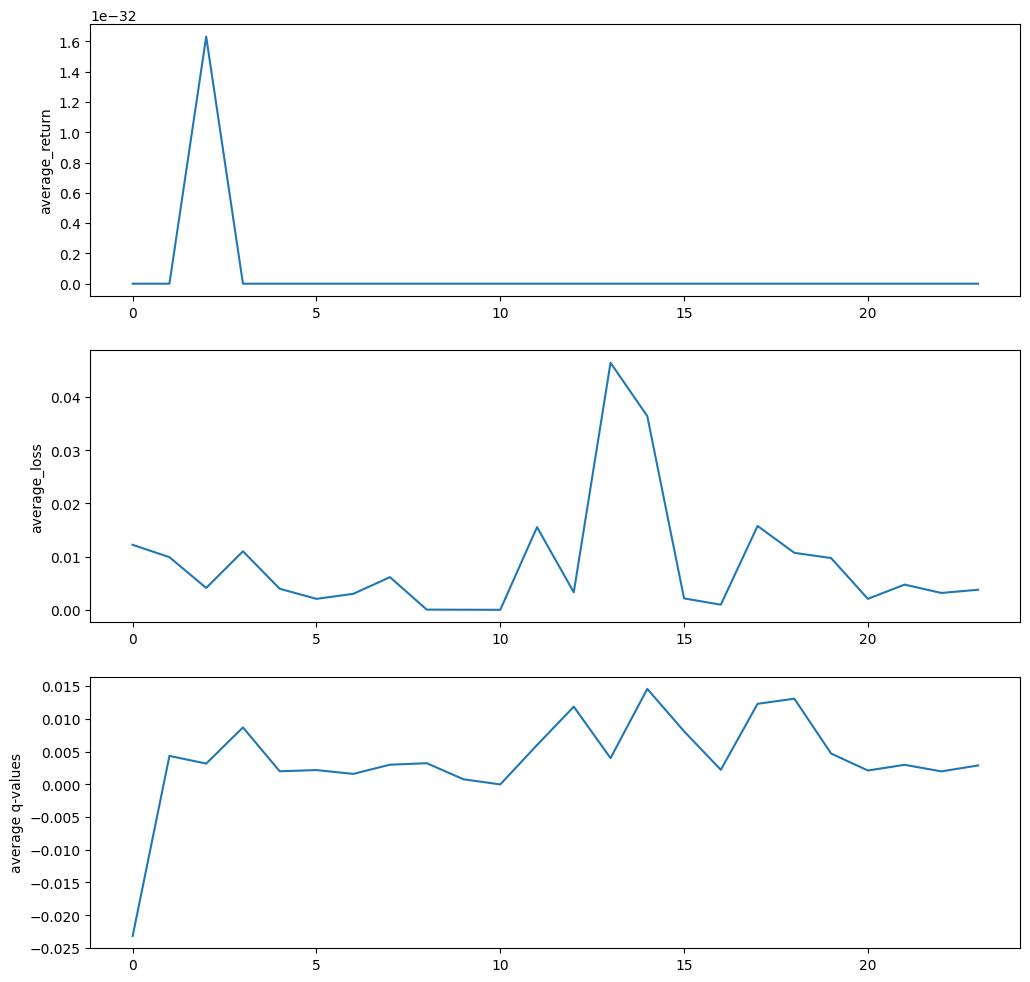

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

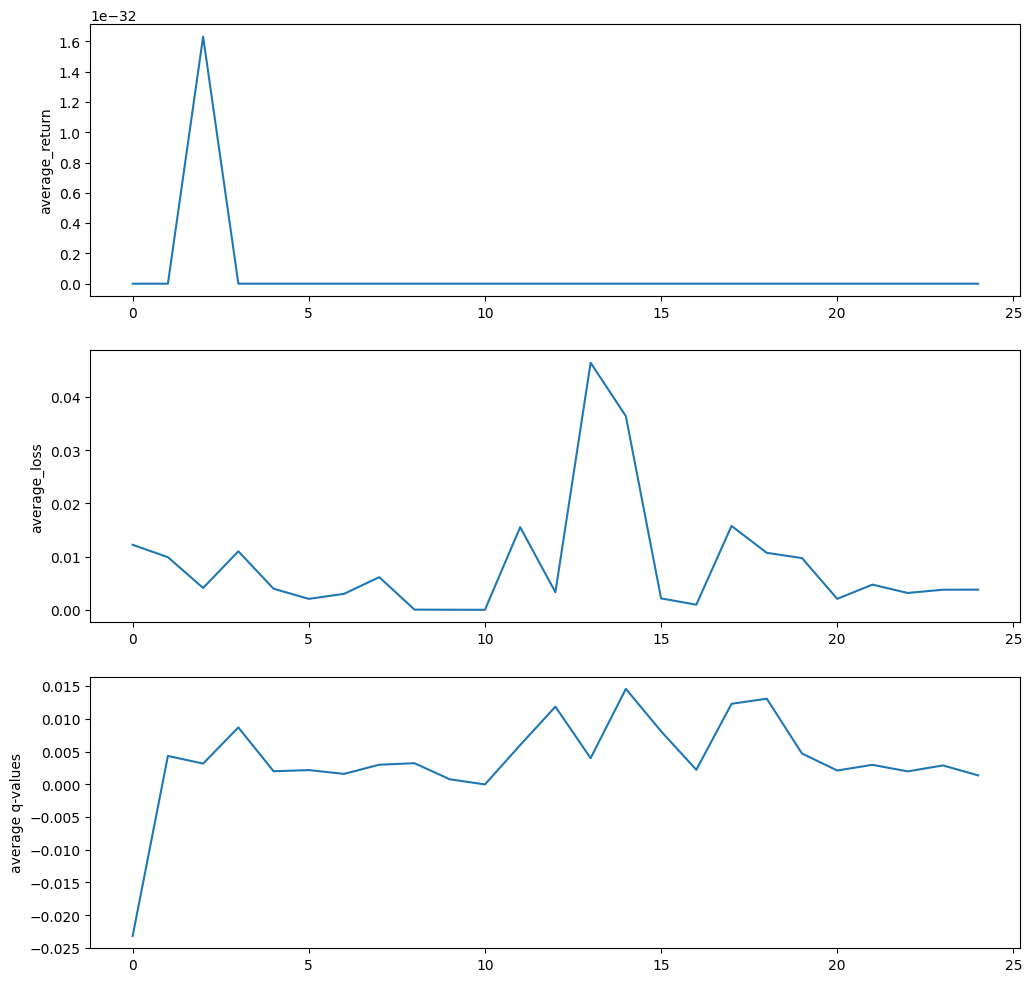

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

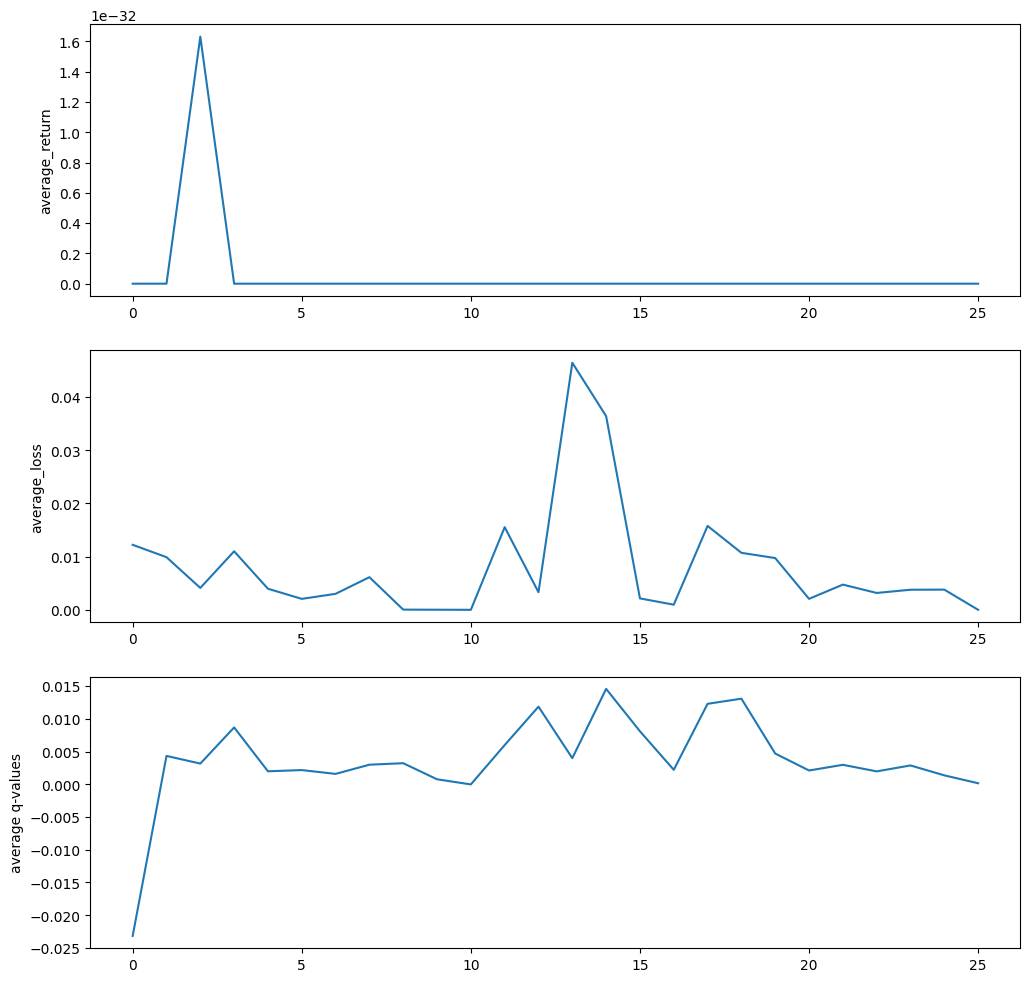

    average_return  average_loss  average q-values
0    6.086880e-144  1.221739e-02         -0.023162
1     4.364507e-61  9.893942e-03          0.004333
2     1.631255e-32  4.110204e-03          0.003162
3     1.651537e-83  1.099879e-02          0.008684
4    4.530050e-201  3.959591e-03          0.001986
5    9.805777e-137  2.057015e-03          0.002168
6    4.871878e-221  3.003759e-03          0.001586
7    1.452319e-304  6.135089e-03          0.002990
8     3.056365e-71  3.476412e-05          0.003219
9     1.619894e-51  1.600505e-05          0.000762
10    0.000000e+00  8.144416e-09         -0.000022
11   1.586109e-262  1.553679e-02          0.005990
12    6.541971e-99  3.304586e-03          0.011854
13    2.626690e-66  4.644611e-02          0.003991
14    7.248721e-97  3.640795e-02          0.014573
15   2.492854e-102  2.145389e-03          0.008094
16    5.656163e-59  9.624552e-04          0.002210
17    3.326239e-64  1.576646e-02          0.012291
18   1.473873e-177  1.071349e-0

In [ ]:
#test everything
if __name__ == '__main__':
  dqn()

#Optimizations
- pre-fill training buffer before training to avoid overestimation bias
- use separate target network, which is a delayed version of Q-network, to avoid moving target problem